In [2]:
!unzip aca-outputs-and-analysis.zip

Archive:  aca-outputs-and-analysis.zip
  inflating: analysis.ipynb          
   creating: outputs/
   creating: outputs/1_linearregression_dgpu-num-dirs_1/
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/citations.bib  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.dot  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.dot.pdf  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.dot.svg  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.ini  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.json  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.system.ruby.dot  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.system.ruby.dot.pdf  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/config.system.ruby.dot.svg  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/stats.txt  
  inflating: outputs/1_linearregression_dgpu-num-dirs_1/system.pc.com_1.device  
   creating: outpu

In [3]:
%pip install numpy pandas seaborn openpyxl

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [5]:
BASE_OUTPUT_DIR = 'outputs'

# Chart style
sns.set_context('paper')
sns.set_theme('paper')
sns.set_style('ticks')

In [6]:
import re

# Define the important statistics prefixes/names
# We use prefixes to catch related sub-stats (like ::mean, ::samples)
statistics_prefixes = {
    # --- Overall ---
    "simSeconds",
    "simInsts",
    "hostInstRate", # For simulation speed context

    # --- CPU 0 (KVM Host) ---
    "system.cpu0.numCycles",
    "system.cpu0.ipc", # With caveat
    "system.cpu0.cpi", # With caveat
    "system.cpu0.numVMExits",
    "system.cpu0.numExitSignal",
    "system.cpu0.numMMIO",
    "system.cpu0.numIO",

    # --- CPU 1 (GPU CU) ---
    "system.cpu1.allLatencyDist::", # Catch mean, samples, stdev, overflows, max_value
    "system.cpu1.loadLatencyDist::",# Catch mean, samples, stdev, overflows, max_value
    "system.cpu1.storeLatencyDist::",# Catch mean, samples, stdev, overflows, max_value
    "system.cpu1.shaderActiveTicks",

    # --- GPU Command Processor ---
    "system.cpu1.gpu_cmd_proc.dispatcher.numKernelLaunched",
    "system.cpu1.gpu_cmd_proc.dispatcher.cyclesWaitingForDispatch",

    # --- DMA ---
    "system.dma_cntrls", # Catch relevant message counts and stall times if needed, focus on active ones

    # --- GPU Memory Controller ---
    "system.gpu_mem_ctrls.avgRdQLen",
    "system.gpu_mem_ctrls.avgWrQLen",
    "system.gpu_mem_ctrls.numRdRetry",
    "system.gpu_mem_ctrls.numWrRetry",
    "system.gpu_mem_ctrls.readReqs",
    "system.gpu_mem_ctrls.writeReqs",
    "system.gpu_mem_ctrls.requestorReadAvgLat::",
    "system.gpu_mem_ctrls.requestorWriteAvgLat::",
    "system.gpu_mem_ctrls.avgRdBWSys",
    "system.gpu_mem_ctrls.avgWrBWSys",
    "system.gpu_mem_ctrls.dram.bwRead::total", # Use total across requestors
    "system.gpu_mem_ctrls.dram.bwWrite::total",# Use total across requestors
    "system.gpu_mem_ctrls.dram.bwTotal::total",# Use total across requestors
    "system.gpu_mem_ctrls.dram.avgQLat",
    "system.gpu_mem_ctrls.dram.avgMemAccLat",
    "system.gpu_mem_ctrls.dram.readRowHitRate",
    "system.gpu_mem_ctrls.dram.writeRowHitRate",
    "system.gpu_mem_ctrls.dram.busUtil",
    "system.gpu_mem_ctrls.dram.pageHitRate",
    "system.gpu_mem_ctrls.rdQLenPdf::", # Include distribution summary/key points if needed
    "system.gpu_mem_ctrls.wrQLenPdf::", # Include distribution summary/key points if needed

    # --- IO Bus ---
    "system.iobus.transDist::", # Catch ReadReq, WriteReq totals

    # --- TLBs ---
    "system.l1_tlb", # Catch accesses, hits, misses, miss rates, latency
    "system.l2_tlb", # Catch accesses, hits, misses, miss rates, latency
    "system.l3_tlb", # Catch accesses, hits, misses, miss rates, latency, pageTableCycles

    # --- System Memory Controllers (Non-GPU specific) ---
    "system.mem_ctrls0.dram.bwTotal::total",
    "system.mem_ctrls0.dram.bytesRead::total",
    "system.mem_ctrls0.dram.bytesWritten::total",
    "system.mem_ctrls1.dram.bwTotal::total",
    "system.mem_ctrls1.dram.bytesRead::total",
    "system.mem_ctrls1.dram.bytesWritten::total",

    # --- Ruby Coherence ---
    "system.ruby.DMA_Controller.ReadRequest::total",
    "system.ruby.DMA_Controller.WriteRequest::total",
    "system.ruby.gpu_dir_cntrl0.L3CacheMemory.m_demand_misses", # Directory accesses
    "system.ruby.gpu_dir_cntrl0.requestFromCores.", # Catch m_buf_msgs, m_avg_stall_time
    "system.ruby.gpu_dir_cntrl0.requestToMemory.", # Catch m_buf_msgs, m_avg_stall_time
    "system.ruby.SQC_Controller.", # Catch major event totals (Fetch::total, Evict::total if available)
    "system.ruby.TCC_Controller.", # Catch major event totals (RdBlk, WrVicBlk, L2_Repl if available - Note: format differs here)
    "system.ruby.TCP_Controller.", # Catch major event totals (Load::total, StoreThrough::total, Evict::total, Repl::total)

    # --- Coalescers ---
    "system.l1_coalescer", # Catch coalesced_accesses, uncoalesced_accesses, local_latency, latency
    "system.l2_coalescer", # Catch coalesced_accesses, uncoalesced_accesses, local_latency, latency
    "system.l3_coalescer", # Catch coalesced_accesses, uncoalesced_accesses, local_latency, latency
    "system.scalar_coalescer", # Catch coalesced_accesses, uncoalesced_accesses, local_latency
    "system.sqc_coalescer", # Catch coalesced_accesses, uncoalesced_accesses, local_latency

    # ---Resource Utilization and Energy----
    "system.cpu0.energy",
    "system.*.power_state.pwrStateResidencyTicks",
}

def parse_gem5_stats(output_dir):
    with open(f'{BASE_OUTPUT_DIR}/{output_dir}/stats.txt') as f:
        stats_text = f.read()

    extracted_data = {}

    # Regex patterns
    # Pattern for simple scalar stats (name value # comment)
    # Handles numbers, nan, True/False
    scalar_pattern = re.compile(r"^([a-zA-Z0-9_\.\-]+)\s+([\d\.\+\-eE]+|nan|True|False|true|false)\s*(?:#.*)?$")

    # Pattern for stats with '::' separator (e.g., name::key value)
    # Handles distribution summaries, requestor stats, power states, transDist, pktSize/Count totals
    dist_summary_pattern = re.compile(r"^([a-zA-Z0-9_\.\-]+)::([a-zA-Z0-9_]+)\s+([\d\.\+\-eE]+|nan)\s*(?:#.*)?$")

    # Pattern specifically for histogram overflows/underflows
    # name::type count percentage cumulative # comment
    overflow_pattern = re.compile(r"^([a-zA-Z0-9_\.\-]+)::(overflows|underflows)\s+(\d+)\s+[\d\.]+%\s+[\d\.]+%\s*(?:#.*)?$")

    # Pattern for Ruby buffer stats (m_*)
    buffer_pattern = re.compile(r"^([a-zA-Z0-9_\.\-]+)\.(m_[a-z_]+)\s+([\d\.\+\-eE]+|nan)\s*(?:#.*)?$")

    # Pattern for Ruby state transitions (more complex, just grabbing totals for now if simple)
    # e.g., system.ruby.DMA_Controller.ReadRequest::total   4391
    ruby_total_pattern = re.compile(r"^([a-zA-Z0-9_\.\-]+)::total\s+(\d+)\s*\(?.*$")

    # Pattern for TCC stats which lack spaces and ::total
    tcc_pattern = re.compile(r"^(system\.ruby\.TCC_Controller\.[A-ZIV_]+)\.([A-Za-z0-9_]+)\s+(\d+)\s+.*$")


    def set_nested_dict(data_dict, key_string, value):
        """Helper to set value in a potentially nested dictionary."""
        keys = key_string.split('.')
        current_level = data_dict
        for i, key in enumerate(keys):
            if i == len(keys) - 1:
                current_level[key] = value
            else:
                current_level = current_level.setdefault(key, {})

    def parse_value(value_str):
        """Attempts to parse string value into int or float, handling 'nan'."""
        if value_str.lower() == 'nan':
            return float('nan')
        if value_str.lower() == 'true':
            return True
        if value_str.lower() == 'false':
            return False
        try:
            return int(value_str)
        except ValueError:
            try:
                return float(value_str)
            except ValueError:
                return value_str # Return as string if not numeric/nan/bool

    lines = stats_text.splitlines()

    for line in lines:
        line = line.strip()
        if not line or line.startswith('#') or line.startswith('---') or 'Begin/End' in line:
            continue

        match = None
        stat_name = None
        stat_key = None
        value = None
        base_name = None # For histogram/distribution stats

        # Try matching patterns (more specific first)
        match = buffer_pattern.match(line)
        if match:
            base_name = match.group(1)
            stat_key = match.group(2)
            stat_name = f"{base_name}.{stat_key}"
            value = parse_value(match.group(3))
        else:
            match = overflow_pattern.match(line)
            if match:
                base_name = match.group(1)
                stat_key = match.group(2) # 'overflows' or 'underflows'
                stat_name = f"{base_name}::{stat_key}"
                value = parse_value(match.group(3)) # Just the count
            else:
                 match = dist_summary_pattern.match(line)
                 if match:
                     base_name = match.group(1)
                     stat_key = match.group(2)
                     stat_name = f"{base_name}::{stat_key}"
                     # Skip power state UNDEFINED for brevity
                     if stat_key == "UNDEFINED" and "pwrStateResidencyTicks" in base_name:
                          continue
                     value = parse_value(match.group(3))
                 else:
                     match = ruby_total_pattern.match(line)
                     if match:
                        base_name = match.group(1)
                        stat_name = f"{base_name}::total"
                        value = parse_value(match.group(2))
                     else:
                         match = tcc_pattern.match(line)
                         if match:
                             base_name = match.group(1)
                             stat_key = match.group(2)
                             stat_name = f"{base_name}.{stat_key}"
                             value = parse_value(match.group(3))
                         else:
                            match = scalar_pattern.match(line)
                            if match:
                                stat_name = match.group(1)
                                # Skip power state ON for brevity unless explicitly needed
                                if stat_name.endswith("power_state.pwrStateResidencyTicks::ON"):
                                    continue
                                value = parse_value(match.group(2))

        # Check if the matched stat is important
        is_important = False
        if stat_name:
            for prefix in statistics_prefixes:
                # Check if stat_name starts with prefix OR
                # if base_name exists and starts with prefix (for :: stats)
                if stat_name.startswith(prefix):
                    is_important = True
                    break
                if base_name and base_name.startswith(prefix):
                     # Special check for latency dists: only keep key summaries
                     if "LatencyDist::" in stat_name and stat_key not in ["mean", "samples", "stdev", "overflows", "underflows", "max_value", "min_value", "total"]:
                          continue # Skip other dist summary stats if not essential
                     is_important = True
                     break
                 # Check for specific TCC stats format
                if "system.ruby.TCC_Controller." in prefix and base_name and base_name.startswith("system.ruby.TCC_Controller."):
                     # Check if the specific event is potentially interesting
                     if stat_key in ["RdBlk", "WrVicBlk", "L2_Repl", "Data", "WBAck"]:
                          is_important = True
                          break

            if is_important:
                 # Use helper to store in nested dict structure
                 # Remove 'system.' prefix for cleaner nesting if present
                 storage_key = stat_name.replace("system.", "", 1)
                 set_nested_dict(extracted_data, storage_key, value)

    return extracted_data

In [7]:
parse_gem5_stats('5_mlpclassifier_tcp-size_64KiB')

{'simSeconds': 15.905206,
 'simInsts': 124817675994,
 'hostInstRate': 740293726,
 'cpu0': {'numCycles': 217592984333,
  'cpi': 1.743287,
  'ipc': 0.573629,
  'numVMExits': 14093224,
  'numExitSignal': 13721412,
  'numMMIO': 74153,
  'numIO': 285696},
 'cpu1': {'allLatencyDist::bucket_size': 10000,
  'allLatencyDist::min_bucket': 0,
  'allLatencyDist::max_bucket': 1599999,
  'allLatencyDist::samples': 135128,
  'allLatencyDist::mean': 1441860.524836,
  'allLatencyDist::stdev': 1231924.271564,
  'allLatencyDist::underflows': 0,
  'allLatencyDist::overflows': 63803,
  'allLatencyDist::min_value': 2000,
  'allLatencyDist::max_value': 20115000,
  'allLatencyDist::total': 135128,
  'loadLatencyDist::bucket_size': 10000,
  'loadLatencyDist::min_bucket': 0,
  'loadLatencyDist::max_bucket': 1599999,
  'loadLatencyDist::samples': 73755,
  'loadLatencyDist::mean': 1391380.164057,
  'loadLatencyDist::stdev': 1465615.052499,
  'loadLatencyDist::underflows': 0,
  'loadLatencyDist::overflows': 29769,

In [8]:
simulations = {
    'run_id': [],
    'workload': [],
    'param': [],
    'value': [],
    'simSeconds': [],
    'cpu_numCycles': [],
    'cpu_cpi': [],
    'gpu_shaderActiveTicks': [],
    'gpu_allLatencyDist_mean': [],
    'gpu_loadLatencyDist_mean': [],
    'gpu_storeLatencyDist_mean': [],
}

output_dirs = os.listdir(BASE_OUTPUT_DIR)

for output_dir in output_dirs:
    parts = output_dir.split('_')
    if len(parts) != 4:
        print(f"Skipping malformed directory name: {output_dir}")
        continue

    run_id, workload, param, value = parts
    stats = parse_gem5_stats(output_dir)

    simulations['run_id'].append(run_id)
    simulations['workload'].append(workload)
    simulations['param'].append(param)
    simulations['value'].append(value)
    simulations['simSeconds'].append(stats.get('simSeconds', np.nan))
    simulations['cpu_numCycles'].append(stats.get('cpu0', {}).get('numCycles', np.nan))
    simulations['cpu_cpi'].append(stats.get('cpu0', {}).get('cpi', np.nan))
    simulations['gpu_shaderActiveTicks'].append(stats.get('cpu1', {}).get('shaderActiveTicks', np.nan))
    simulations['gpu_allLatencyDist_mean'].append(stats.get('cpu1', {}).get('allLatencyDist::mean', np.nan))
    simulations['gpu_loadLatencyDist_mean'].append(stats.get('cpu1', {}).get('loadLatencyDist::mean', np.nan))
    simulations['gpu_storeLatencyDist_mean'].append(stats.get('cpu1', {}).get('storeLatencyDist::mean', np.nan))


simulations_df = pd.DataFrame(simulations)
simulations_df

,run_id,workload,param,value,simSeconds,cpu_numCycles,cpu_cpi,gpu_shaderActiveTicks,gpu_allLatencyDist_mean,gpu_loadLatencyDist_mean,gpu_storeLatencyDist_mean
0,4,matrixmultiplication,tcc-size,384KiB,26.669514,109217736299,0.691438,2903044696,1.712063e+06,1.979659e+06,1.479498e+06
1,4,mlpclassifier,gpu-clock,1.5GHz,16.344841,198372807533,1.584366,10799610252,1.398363e+06,1.407485e+06,1.387399e+06
2,2,mlpclassifier,tcc-size,512KiB,16.879322,204453338965,1.633284,11195185207,1.431748e+06,1.377598e+06,1.496823e+06
3,1,matrixmultiplication,num-compute-units,8,26.766785,108424912483,0.686939,2675788696,3.019773e+06,3.472572e+06,2.626250e+06
4,2,matrixmultiplication,num-compute-units,8,26.553175,108557166470,0.682561,2682980696,3.077512e+06,3.514345e+06,2.697867e+06
...,...,...,...,...,...,...,...,...,...,...,...
355,5,mlpclassifier,num-tccs,2,15.967254,200941022865,1.606500,11218923207,1.431584e+06,1.377016e+06,1.497160e+06
356,3,matrixmultiplication,num-compute-units,8,26.889939,108744325520,0.687511,2676266696,3.175137e+06,3.593303e+06,2.811715e+06
357,3,linearregression,gpu-clock,2GHz,15.555882,103826759809,0.875525,4286676170,1.433243e+06,1.579123e+06,1.280077e+06
358,4,linearregression,num-compute-units,8,15.280014,103378142878,0.875026,4027785670,2.703854e+06,2.788894e+06,2.614566e+06


In [10]:
simulations_df.to_excel('results.xlsx', index=False)

In [11]:
def plot(param, stat, col_order=None):
    df_filtered = simulations_df[simulations_df['param'] == param].copy()
    df_filtered['value'] = df_filtered['value'].astype(str).str.replace(r'[^-0-9.]', '', regex=True)
    df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')
    df_sorted = df_filtered.sort_values(by=['value'])
    g = sns.catplot(
        df_sorted,
        kind='box',
        x='value',
        y=stat,
        col='workload',
        sharey=False,
        col_order=col_order,
    )
    g.set_xlabels(param)
    return g

In [12]:
params = simulations_df['param'].unique().tolist()
stats = [col for col in simulations_df.columns if col not in ['run_id', 'workload', 'param', 'value']]
workload_order = ['matrixmultiplication', 'linearregression', 'mlpclassifier']

print(f'{ params = }')
print(f'{ stats = }')
print(f'{ workload_order = }')

 params = ['tcc-size', 'gpu-clock', 'num-compute-units', 'dgpu-num-dirs', 'num-tccs', 'tcp-size']
 stats = ['simSeconds', 'cpu_numCycles', 'cpu_cpi', 'gpu_shaderActiveTicks', 'gpu_allLatencyDist_mean', 'gpu_loadLatencyDist_mean', 'gpu_storeLatencyDist_mean']
 workload_order = ['matrixmultiplication', 'linearregression', 'mlpclassifier']


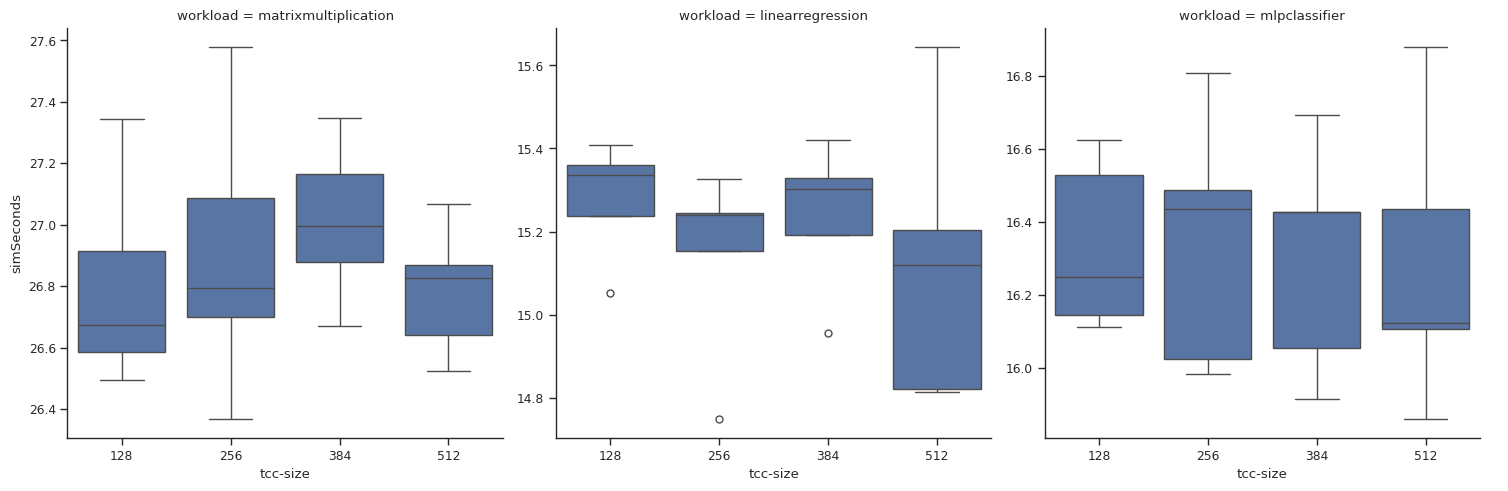

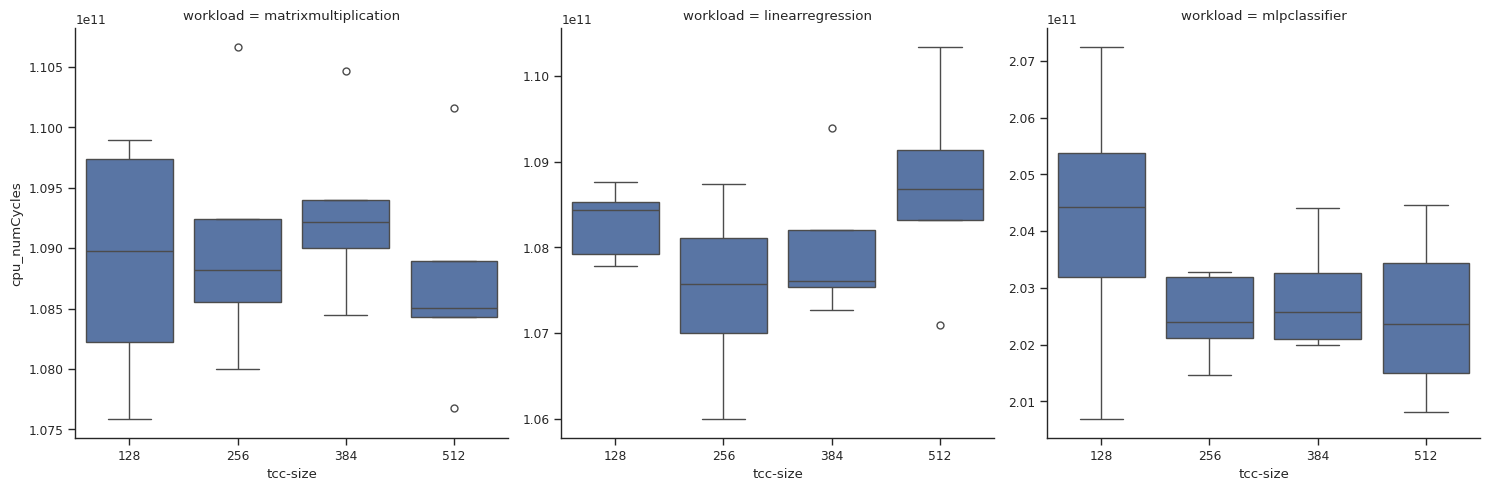

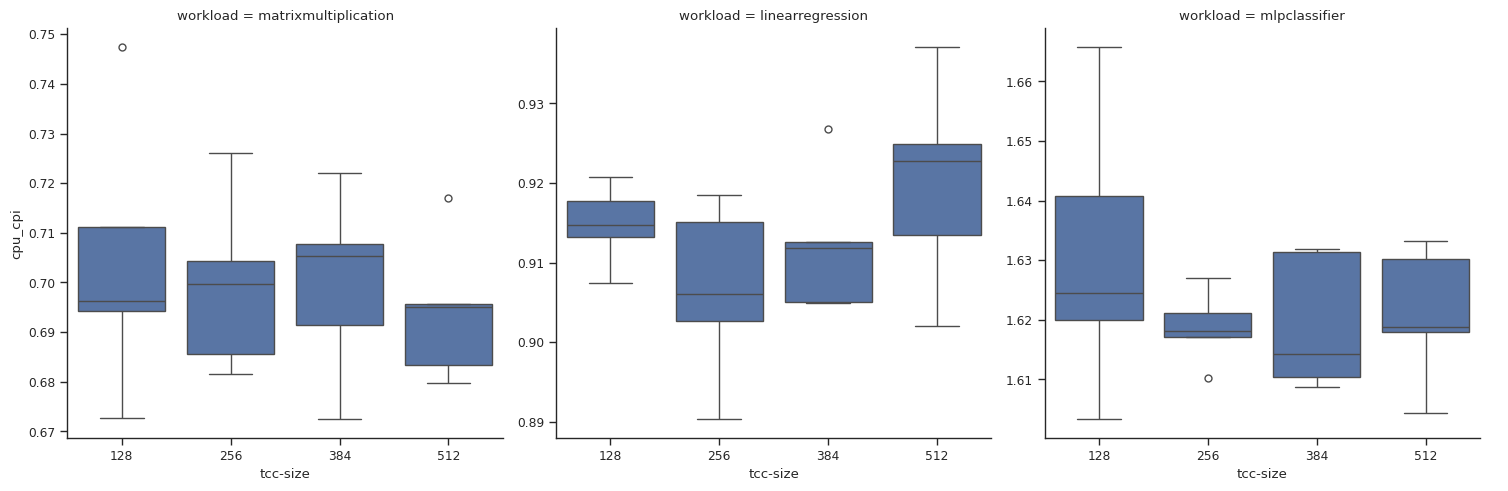

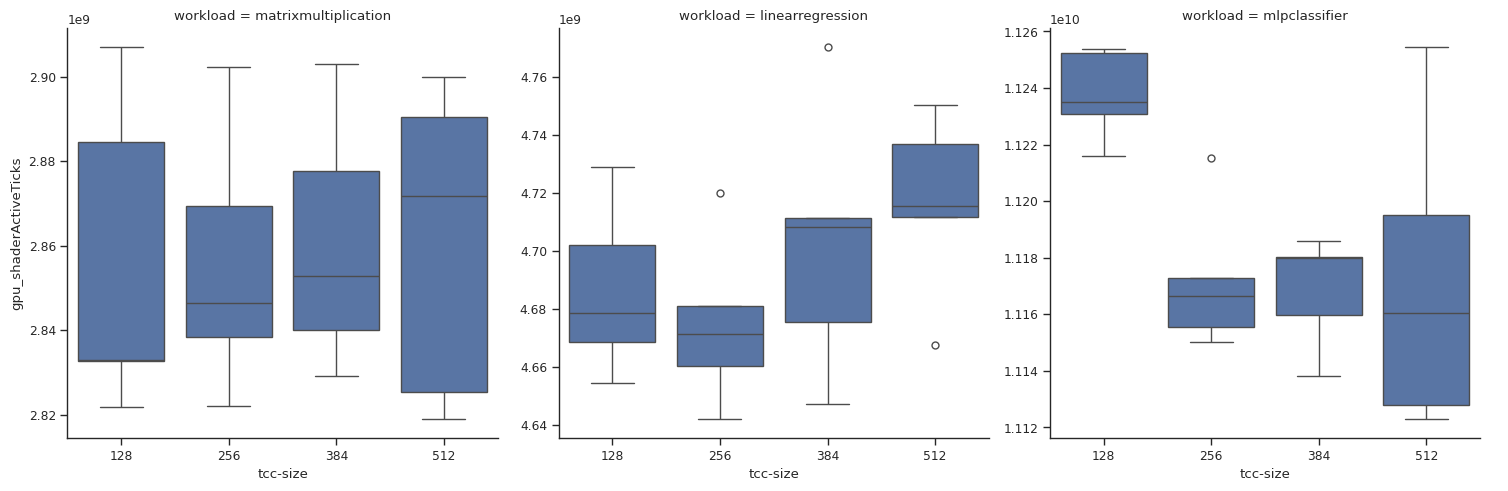

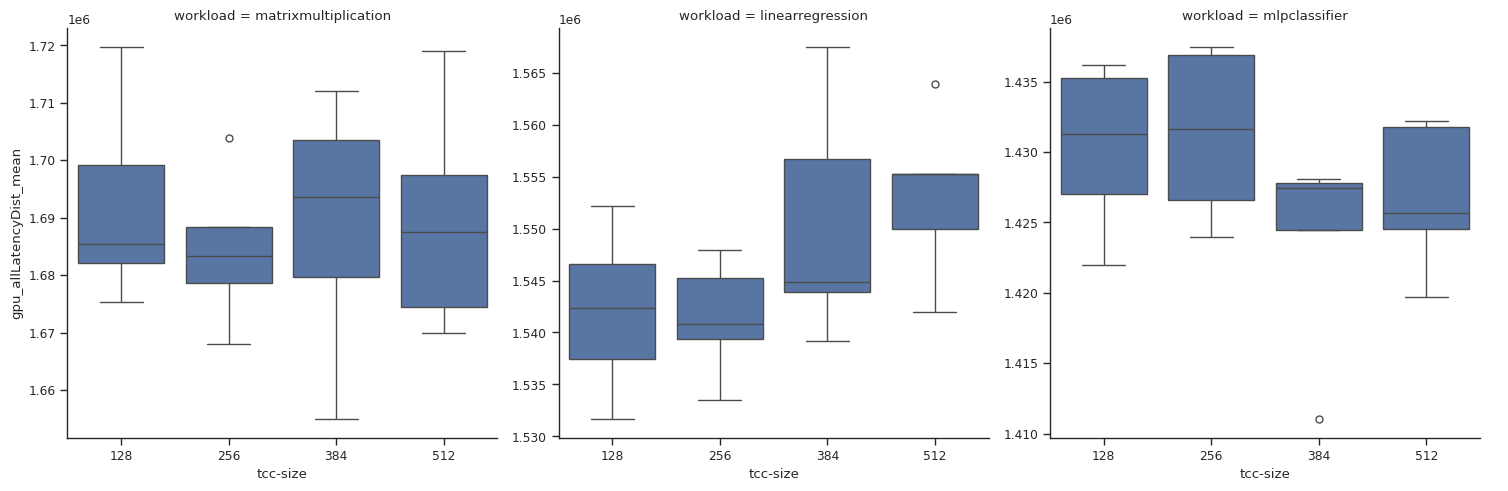

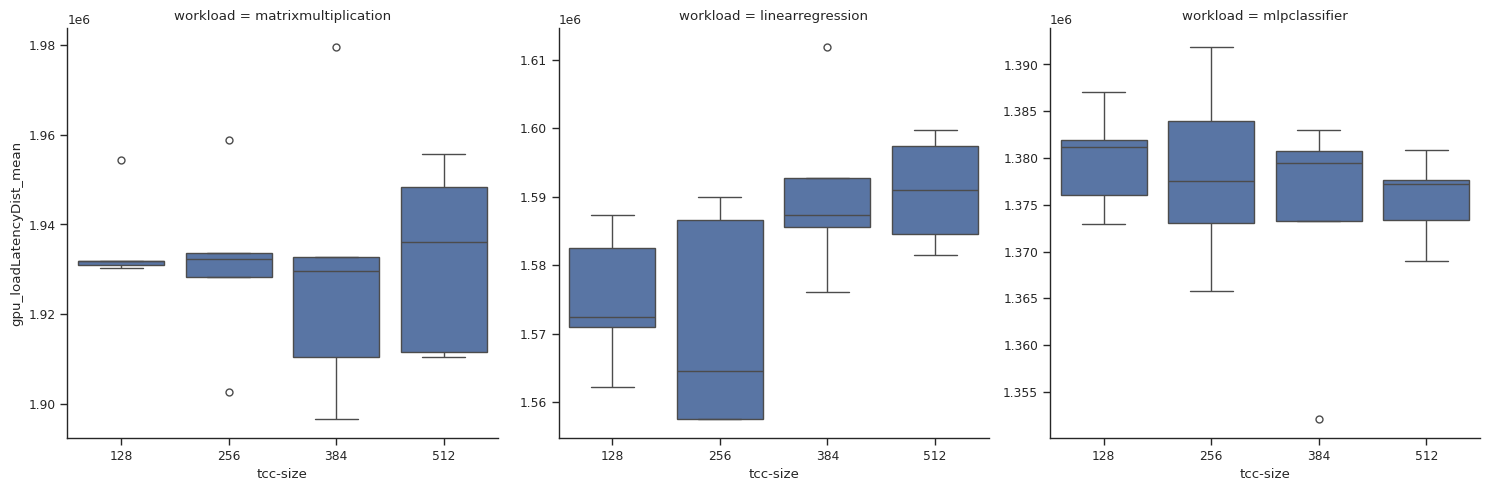

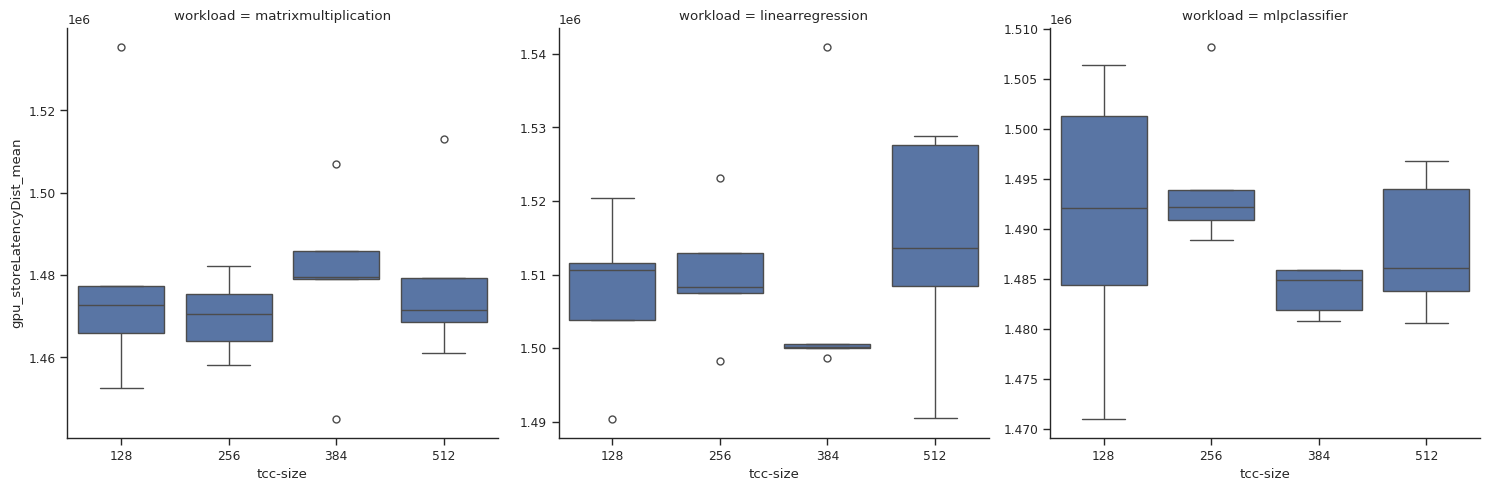

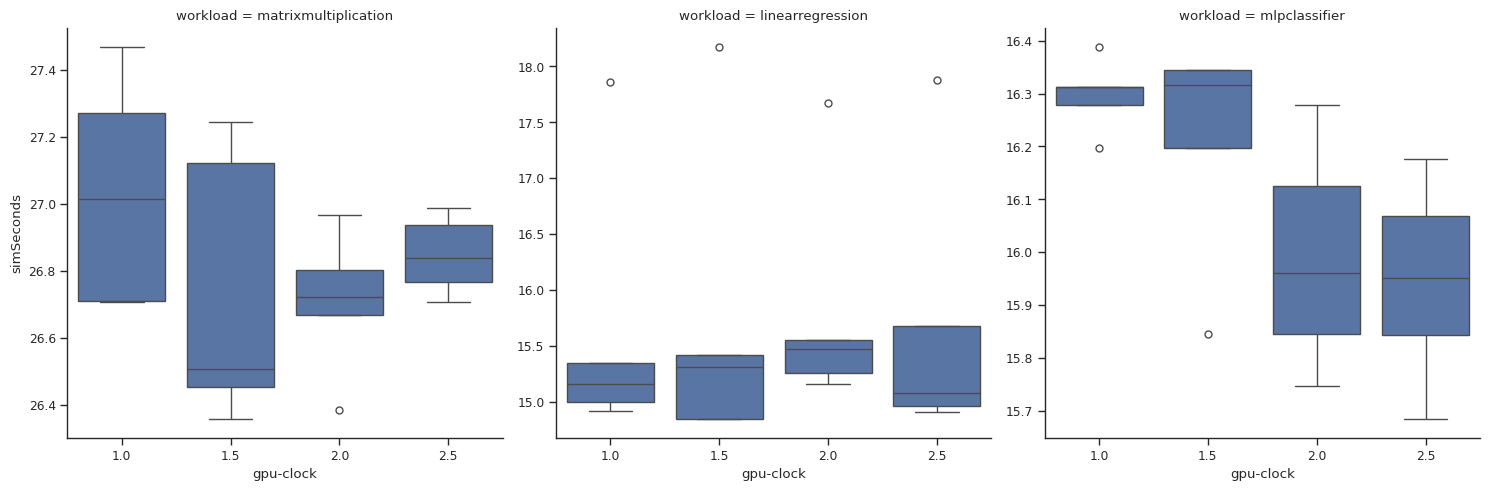

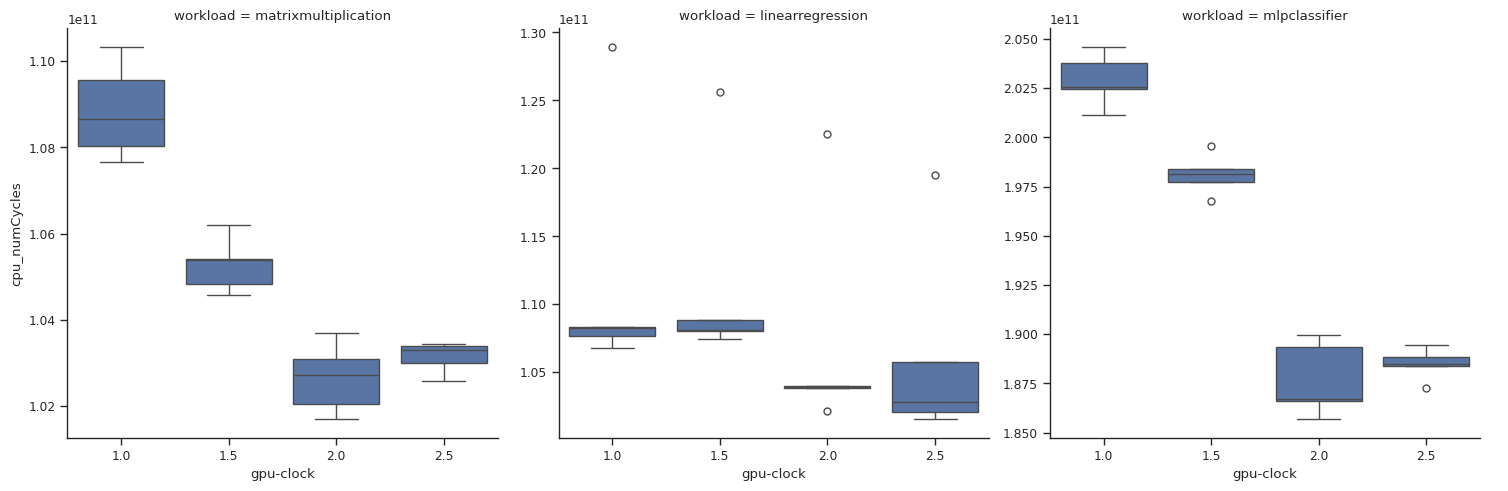

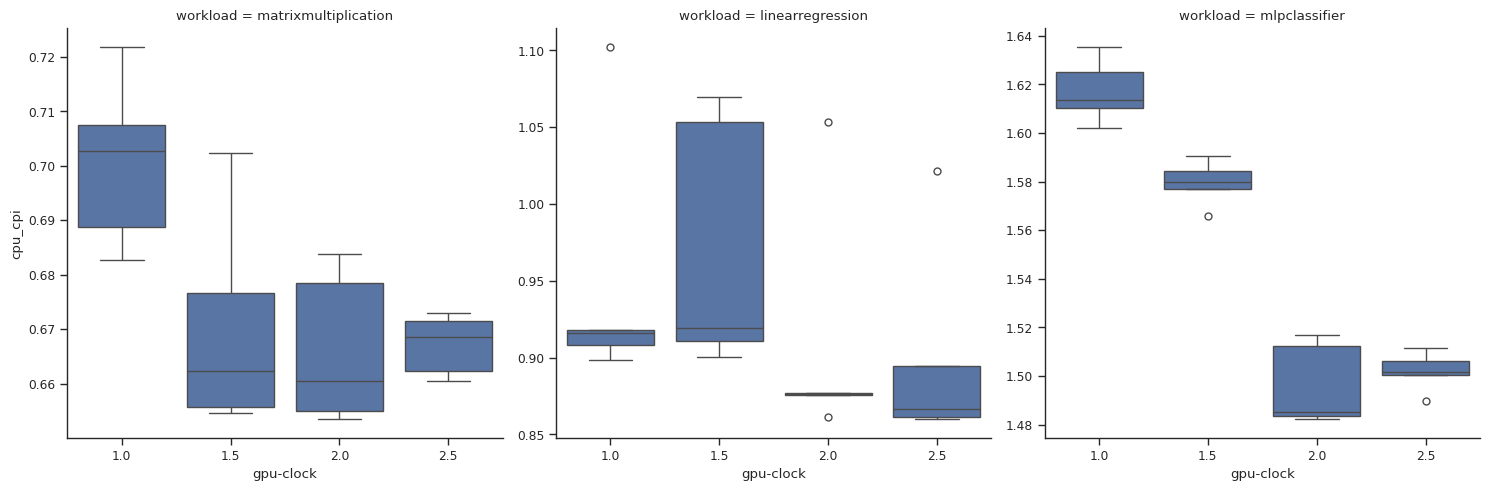

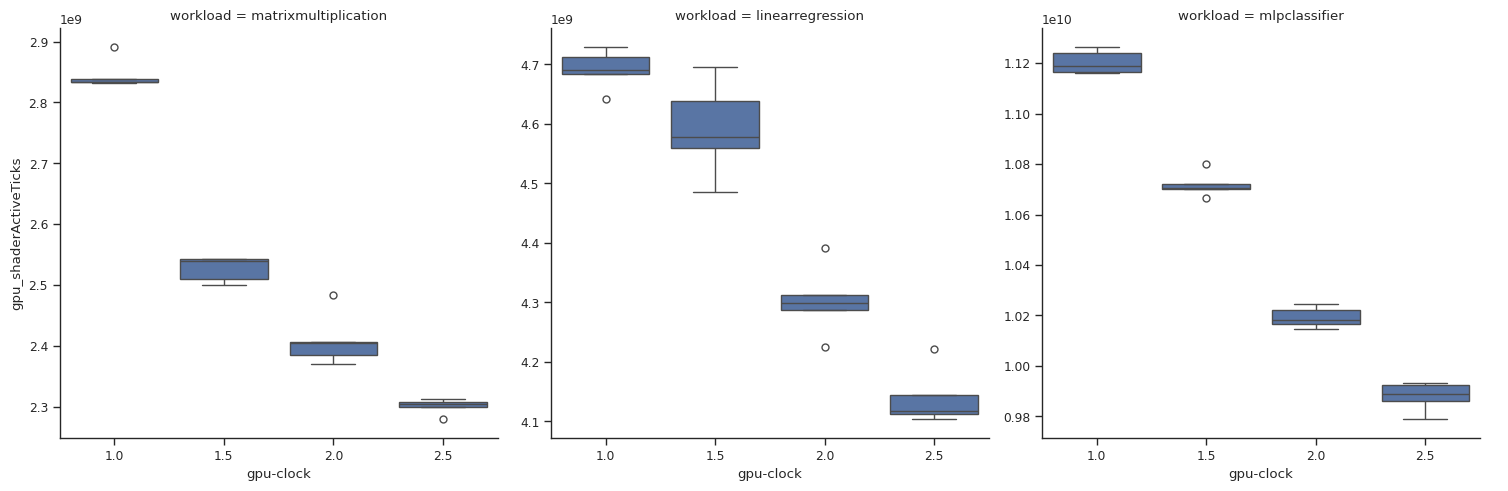

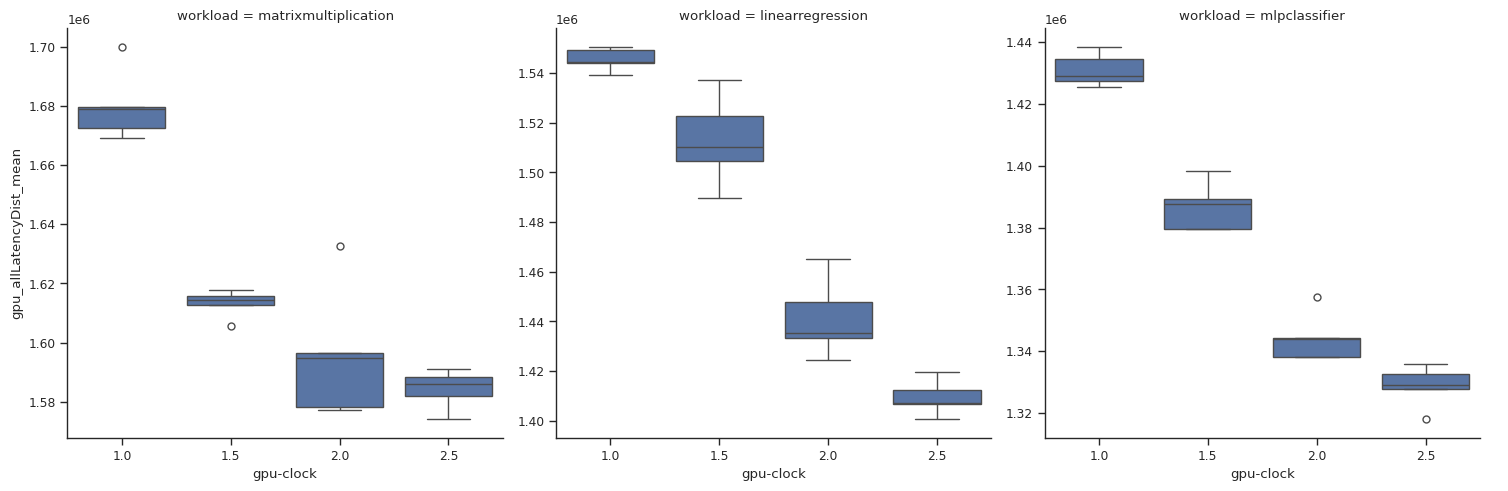

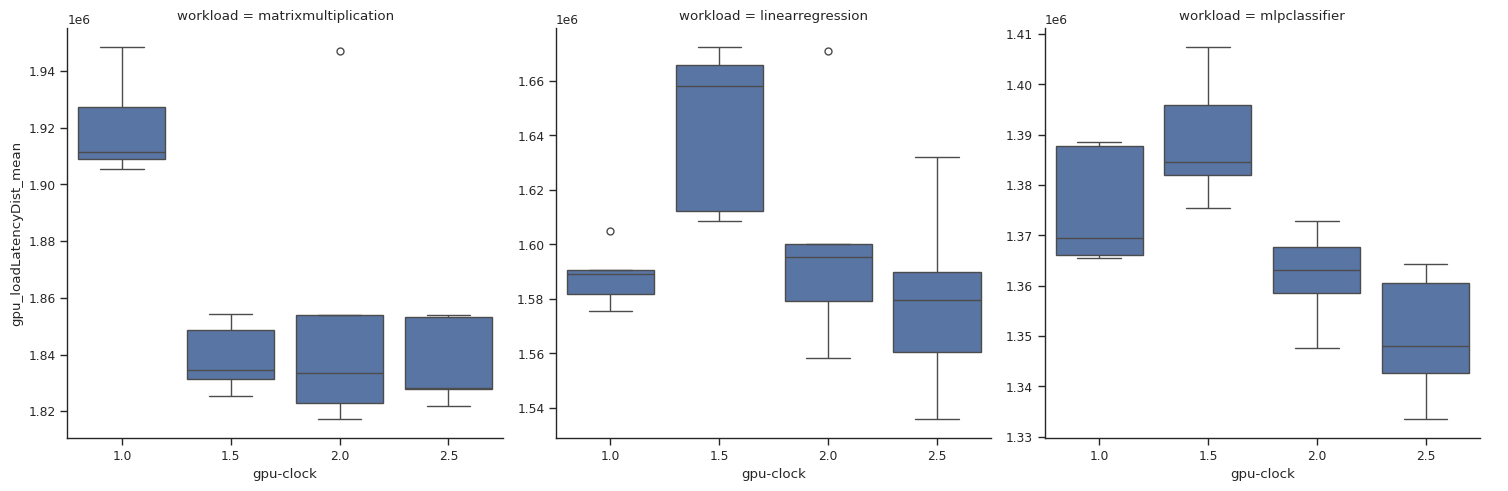

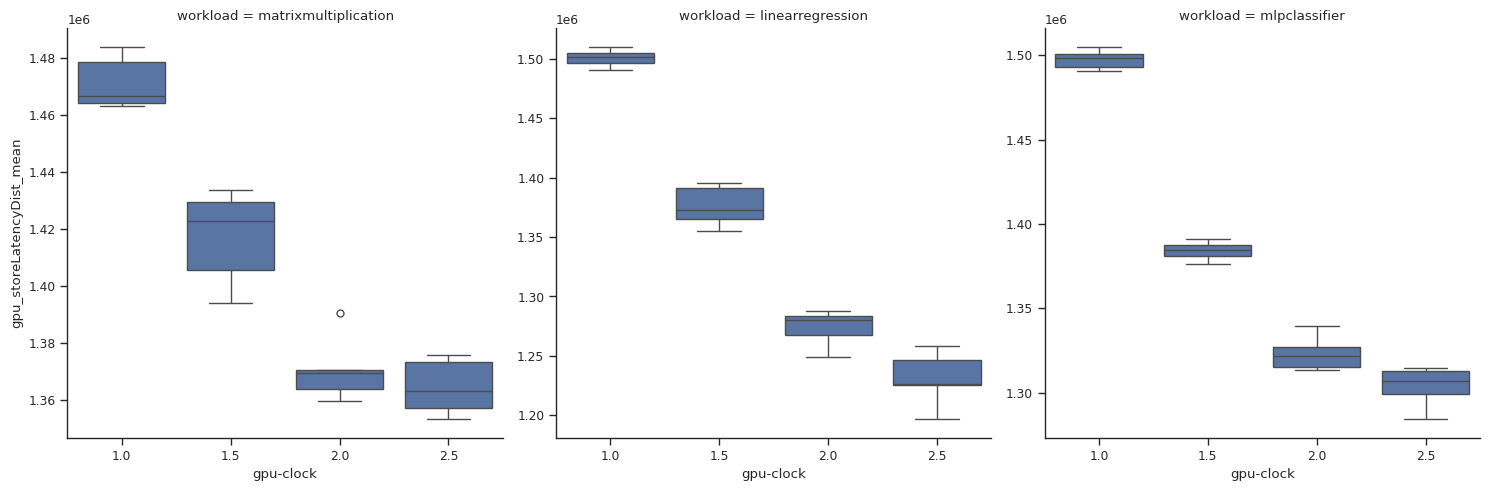

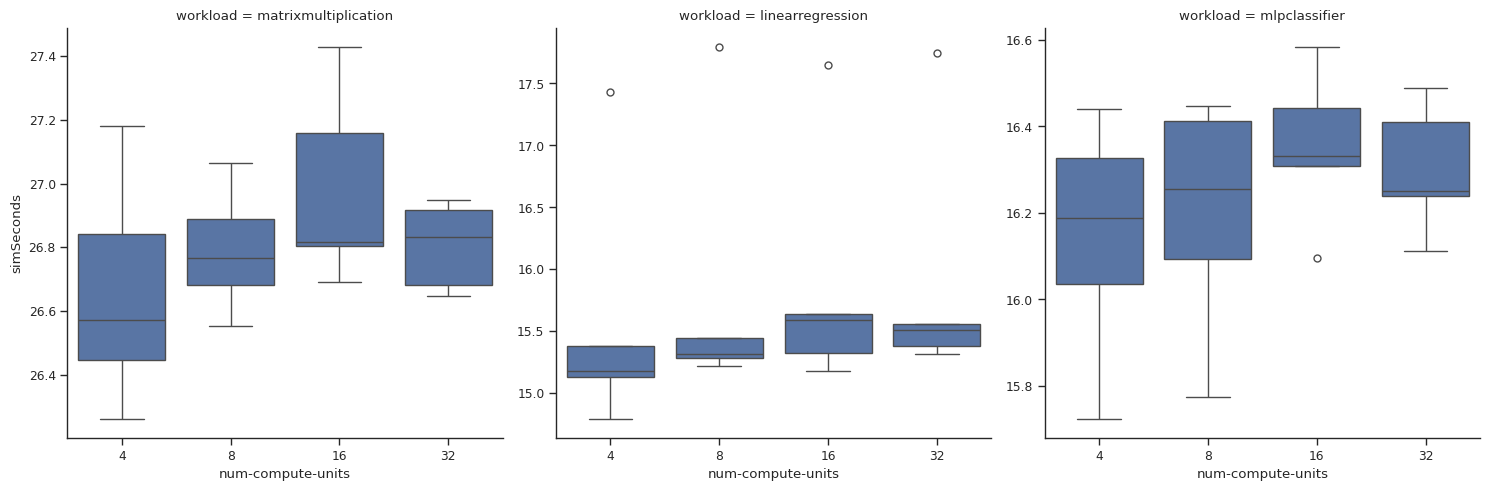

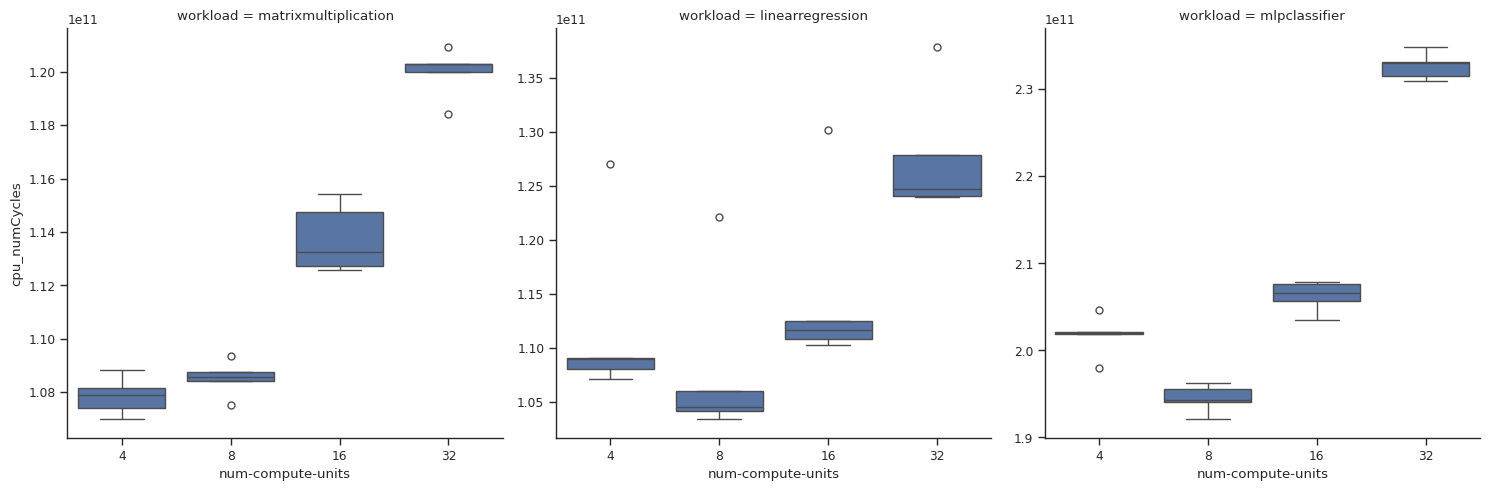

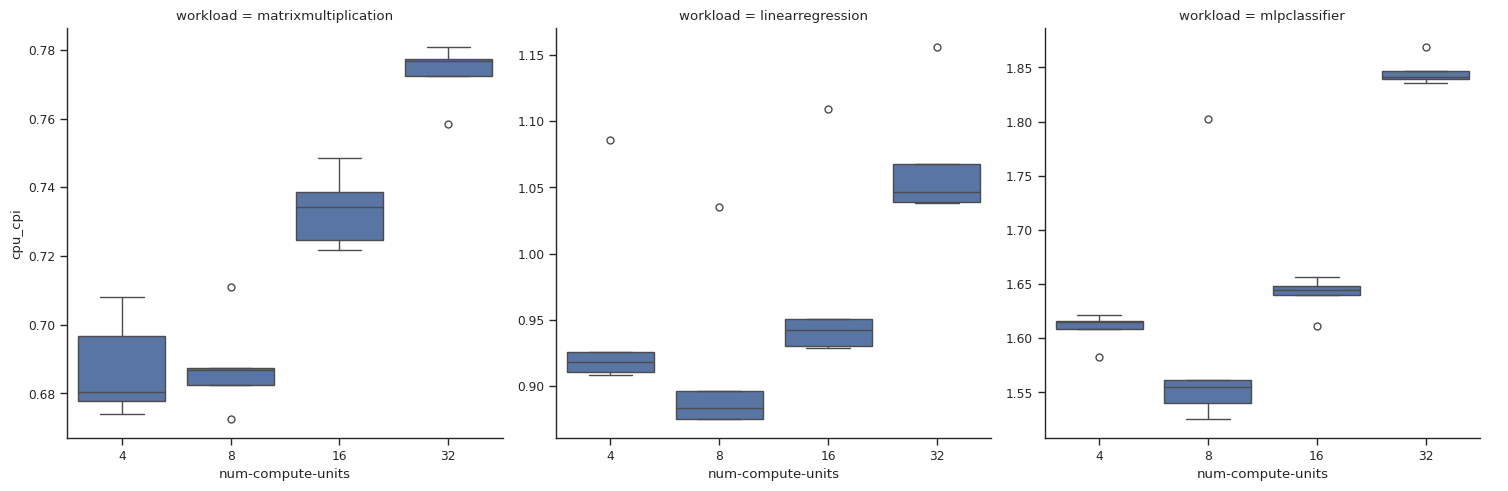

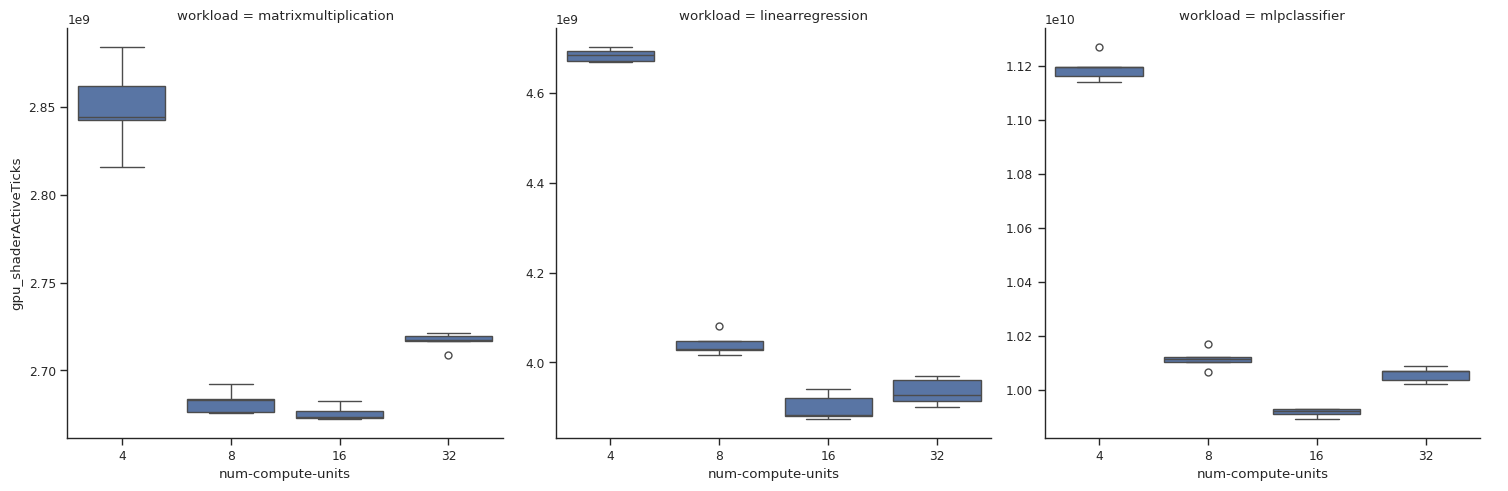

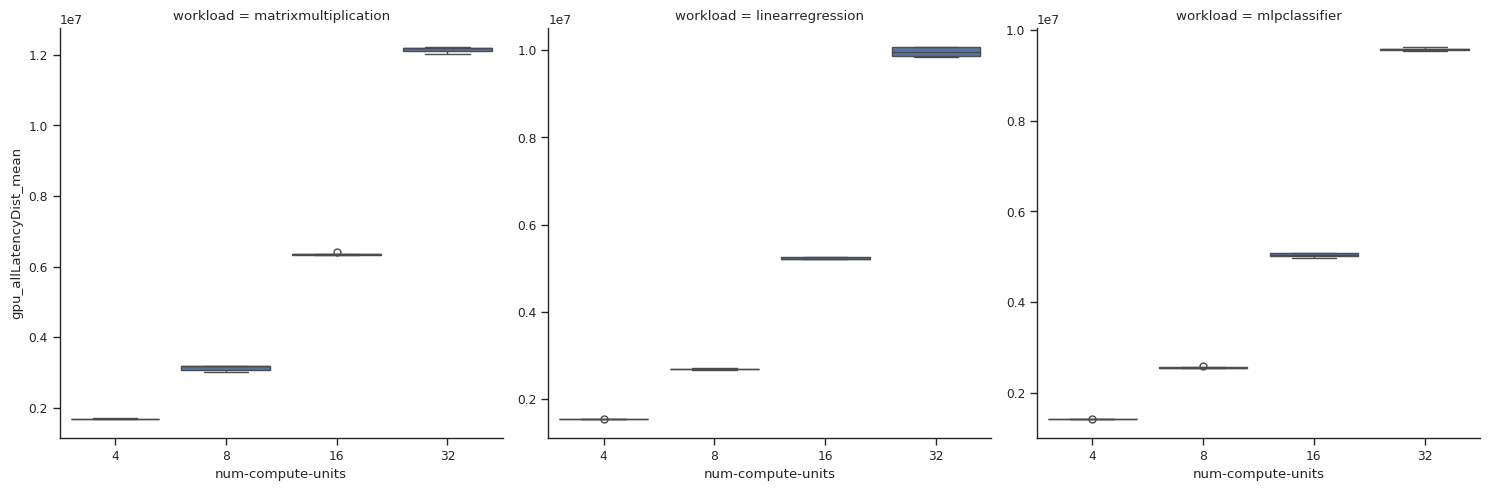

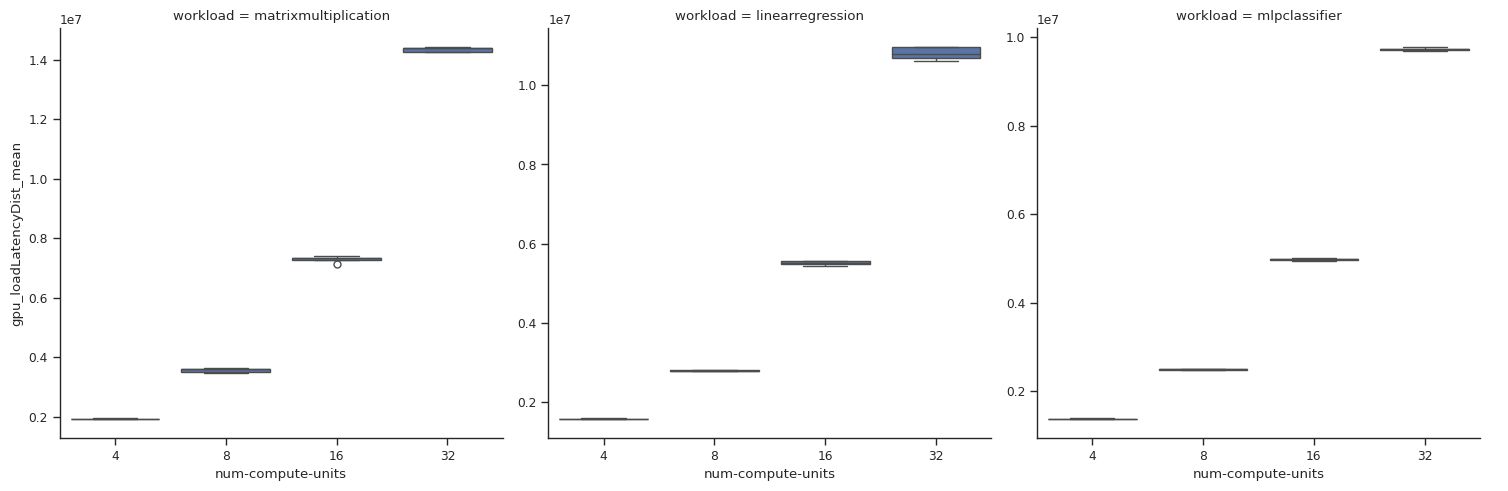

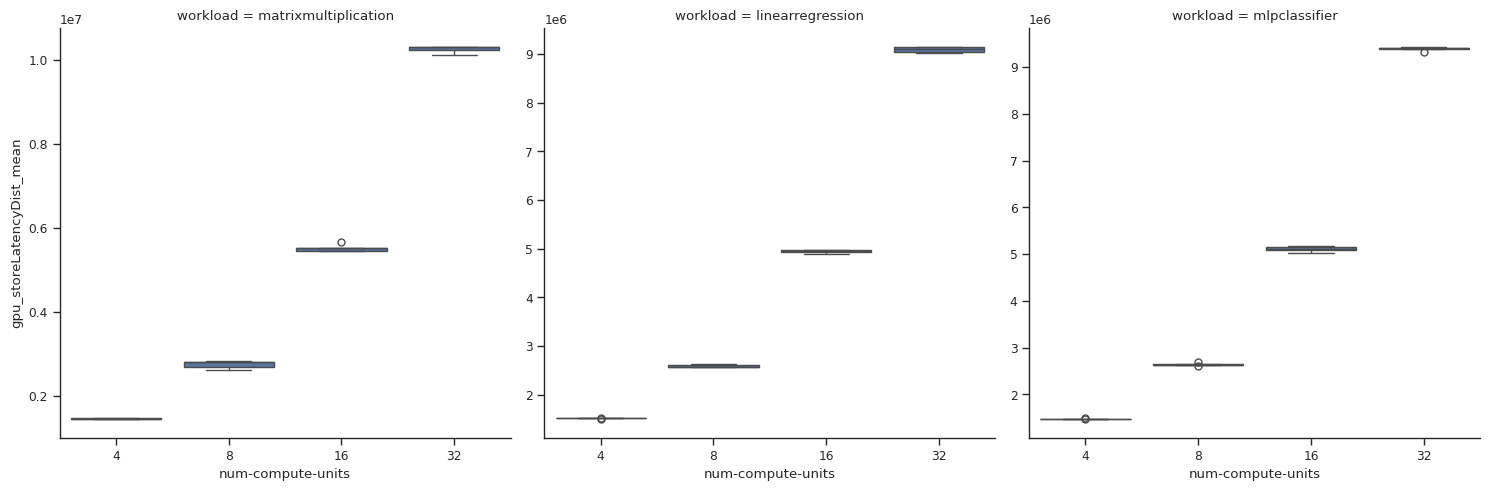

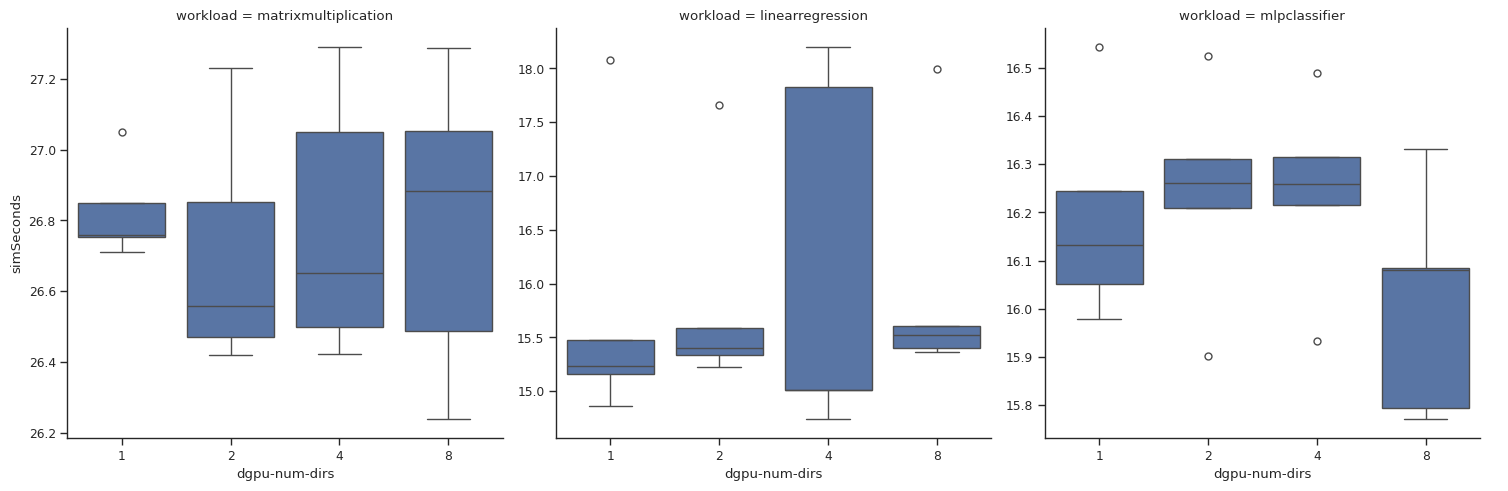

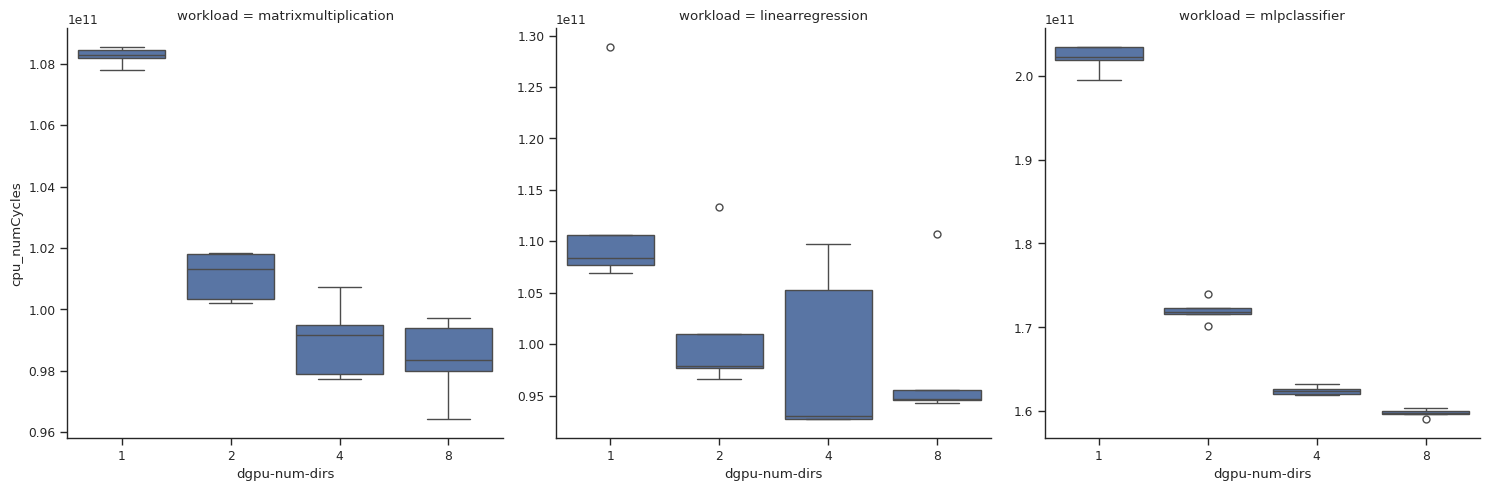

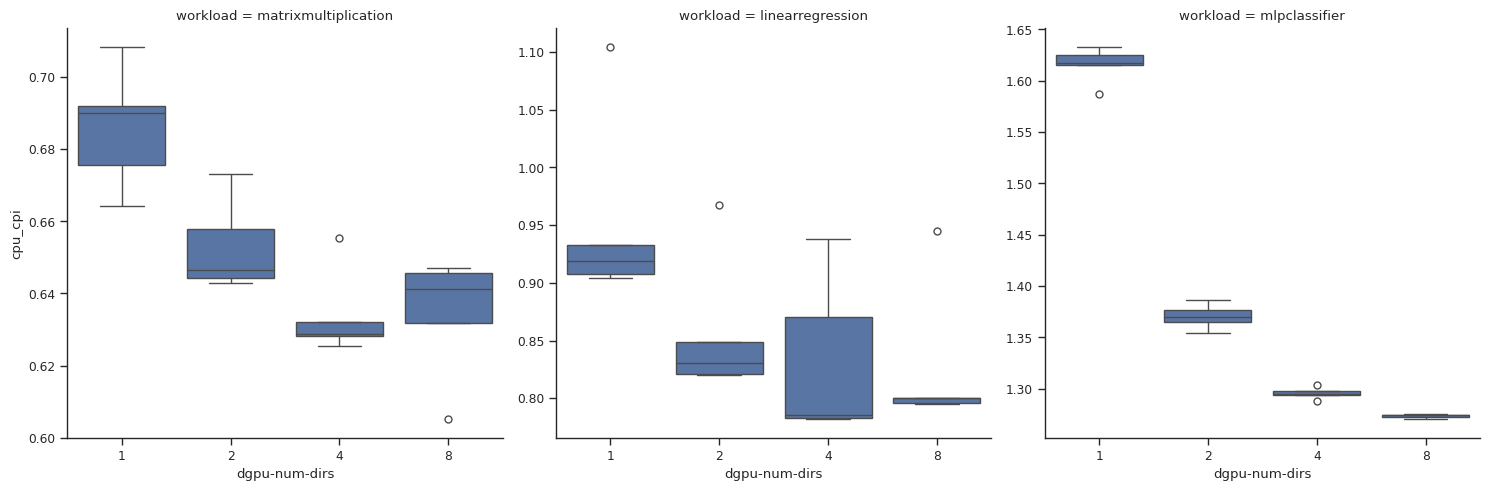

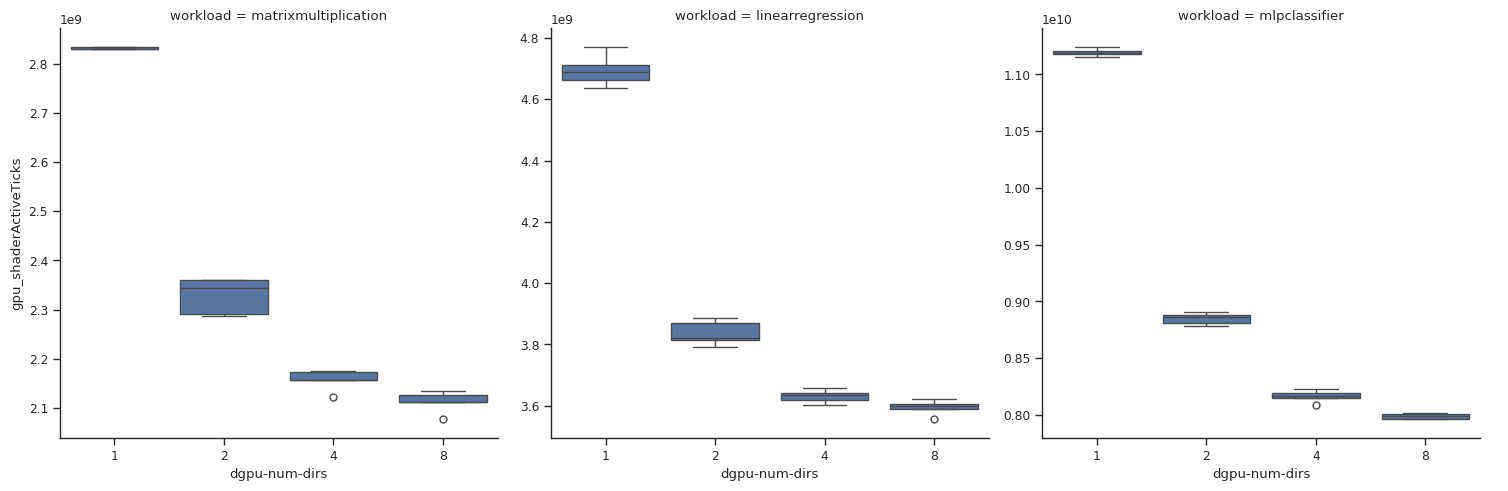

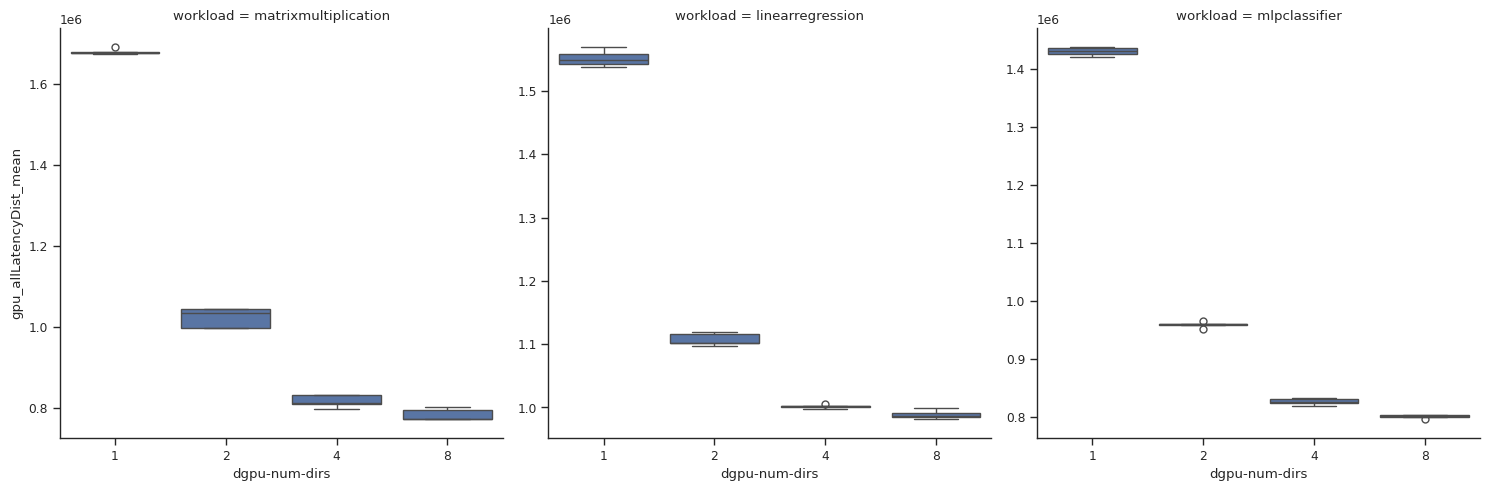

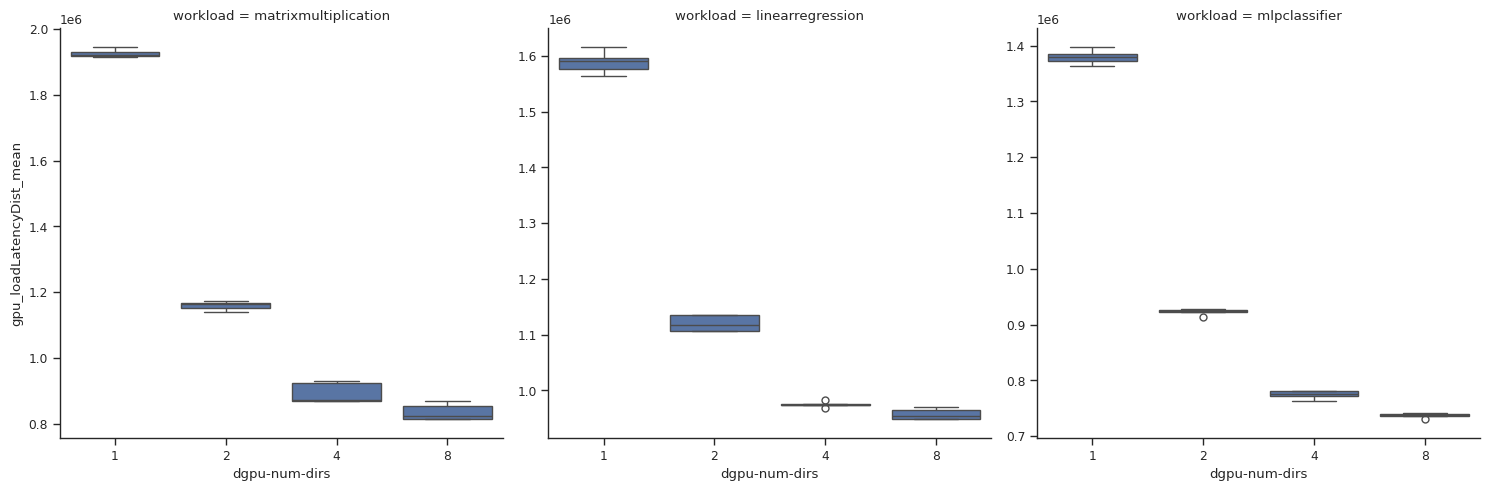

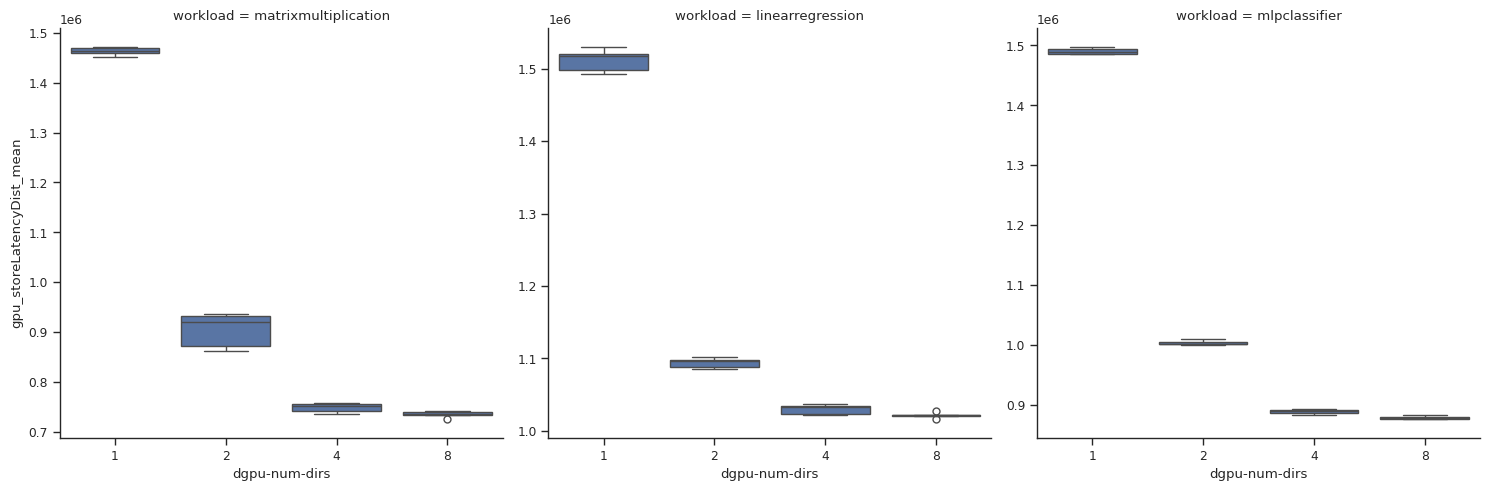

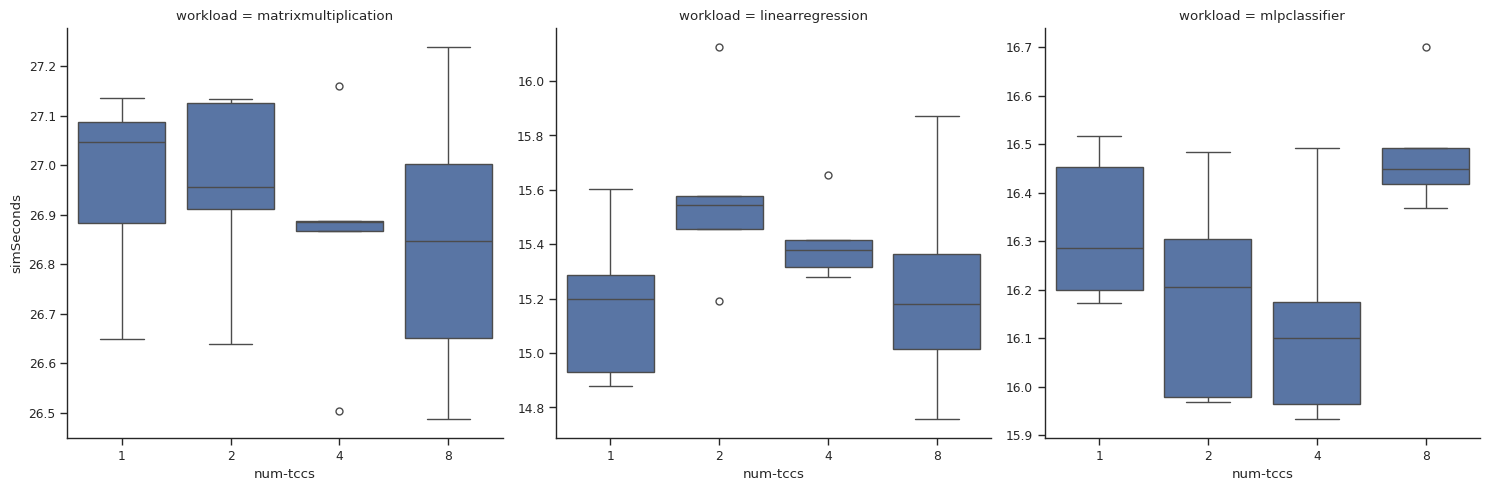

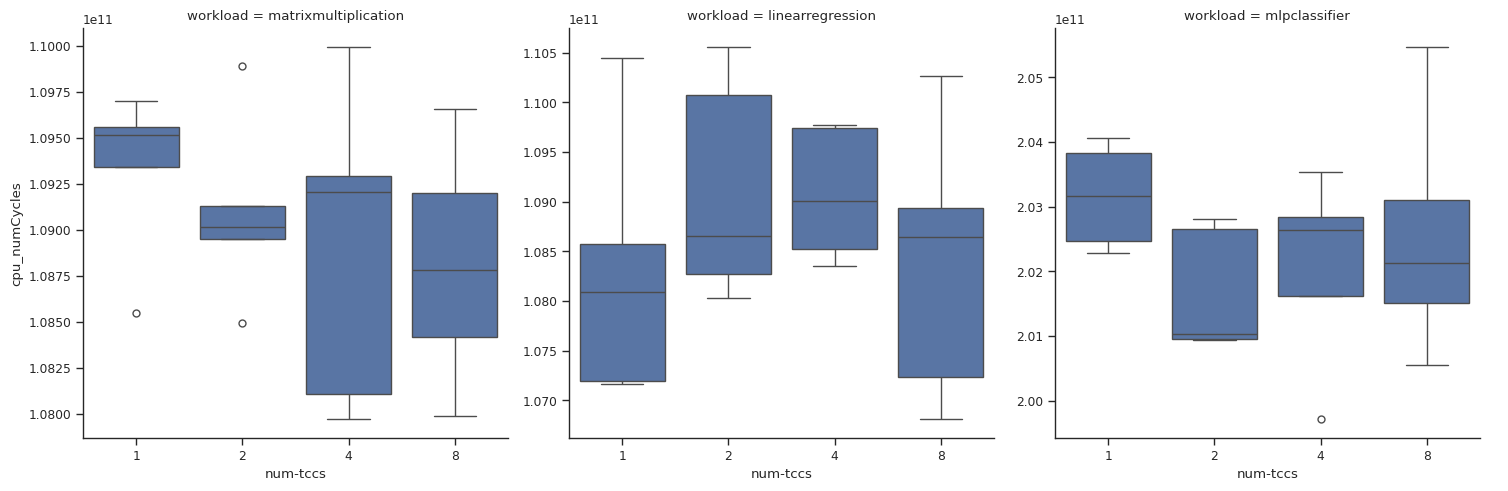

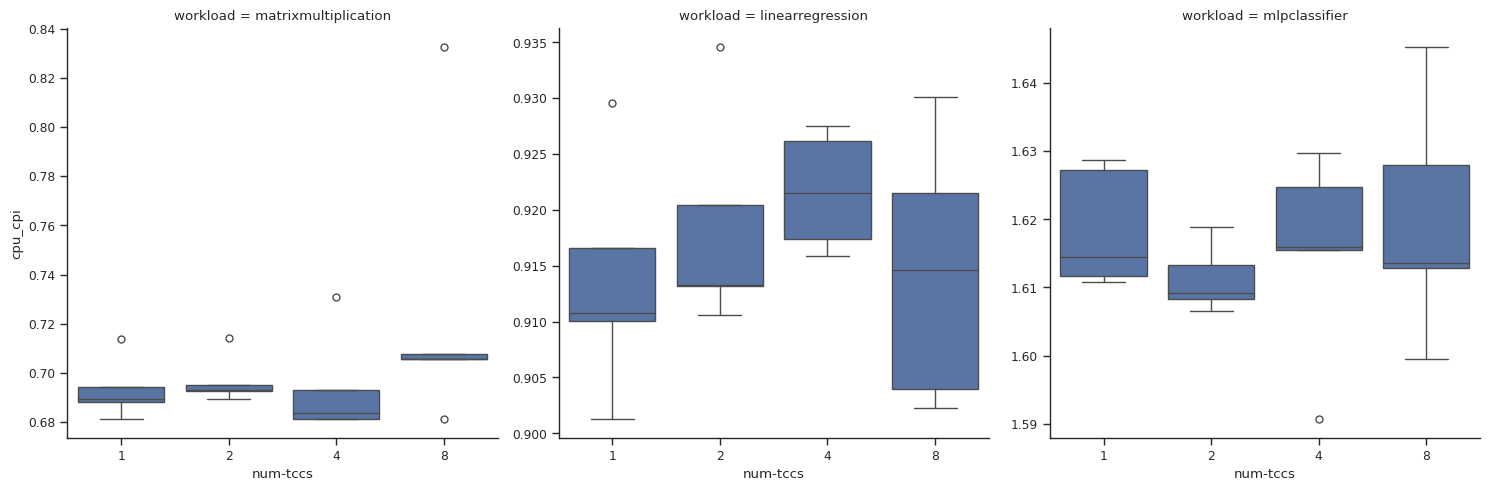

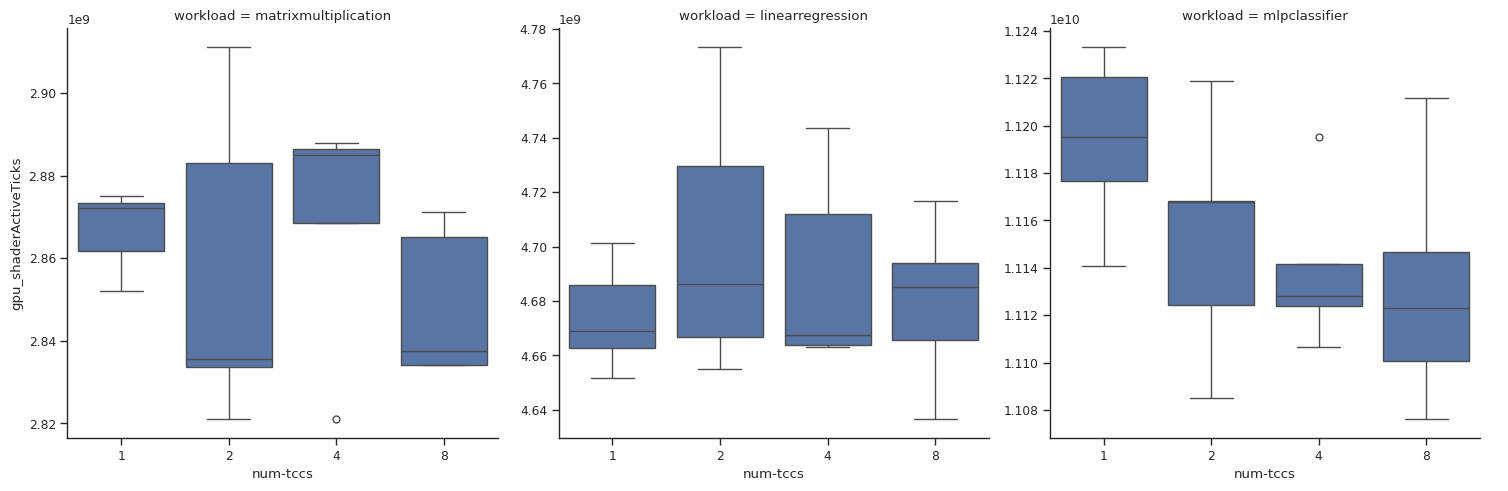

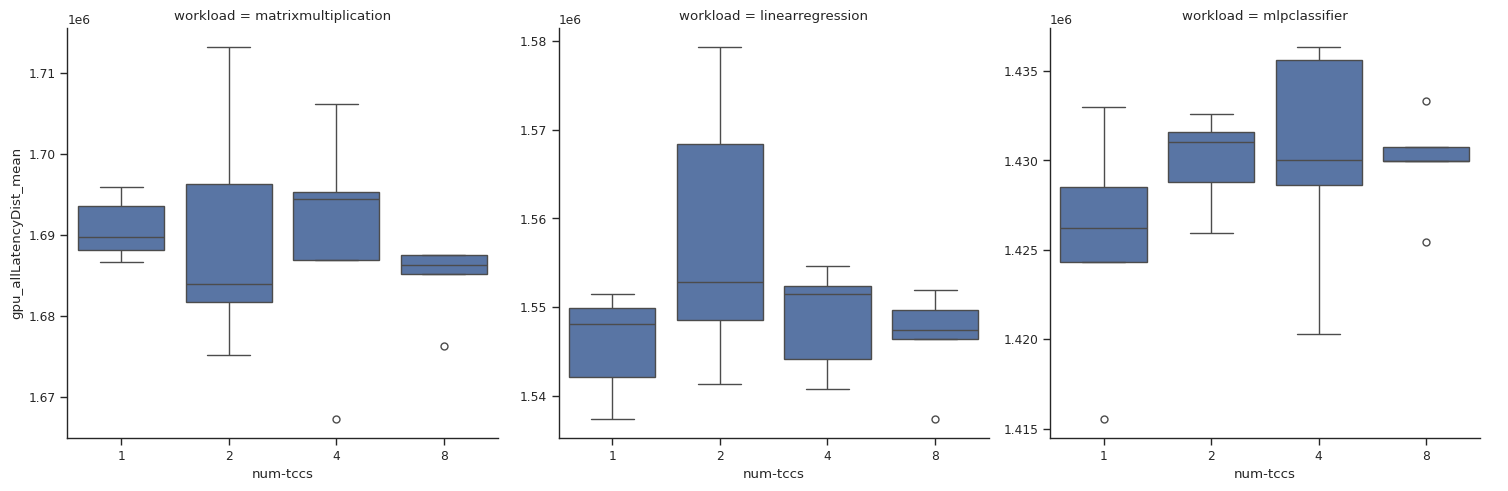

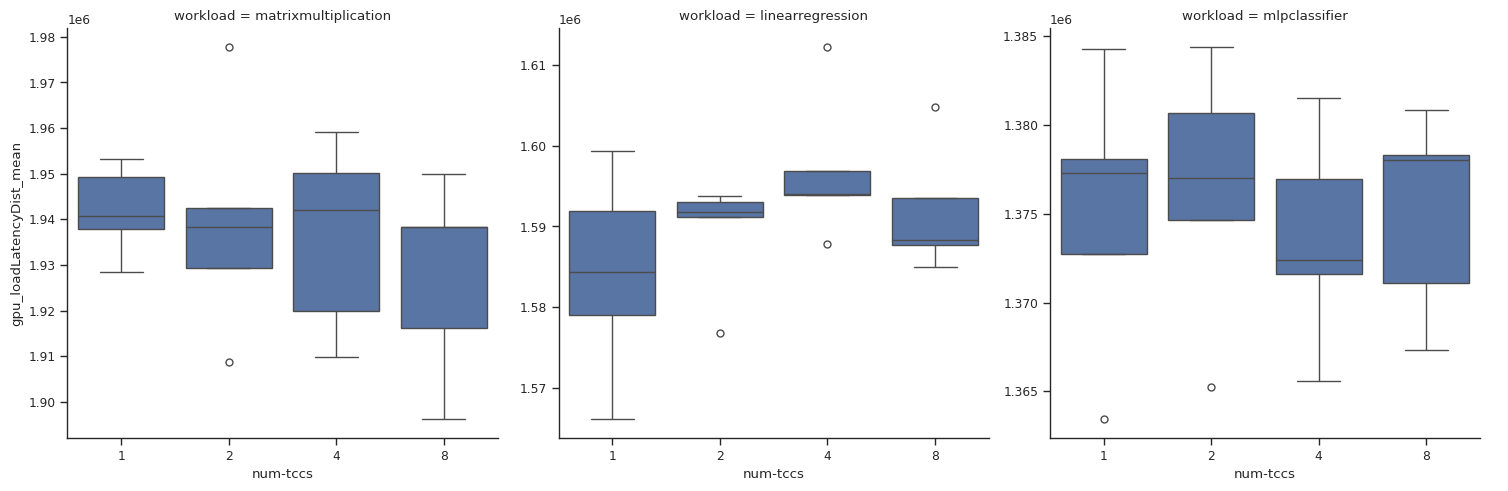

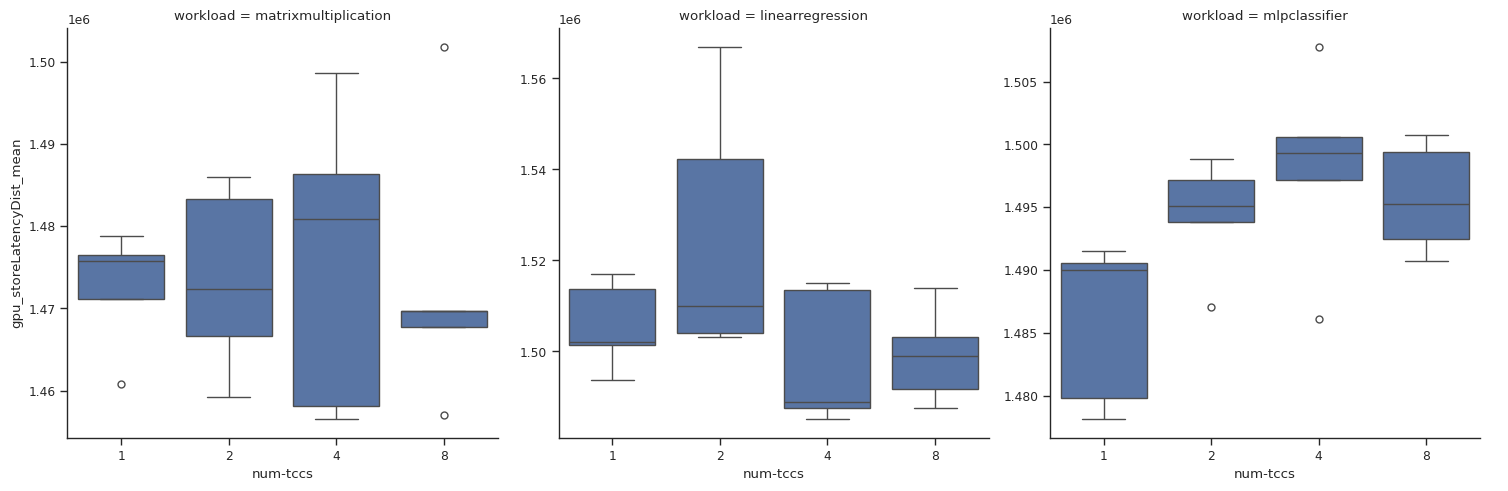

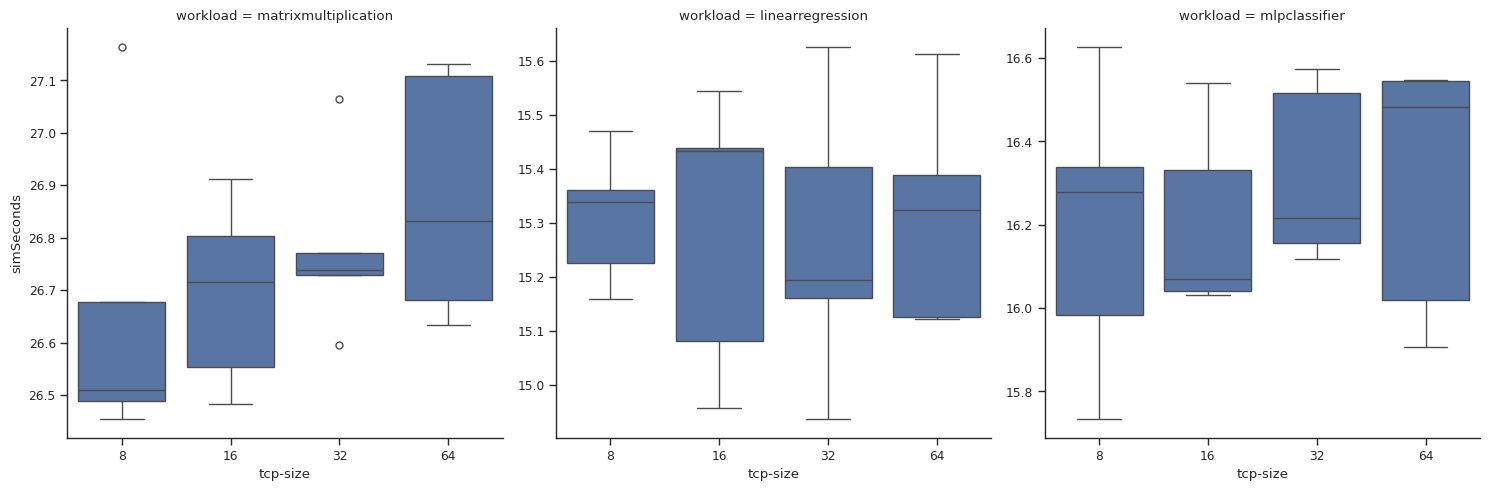

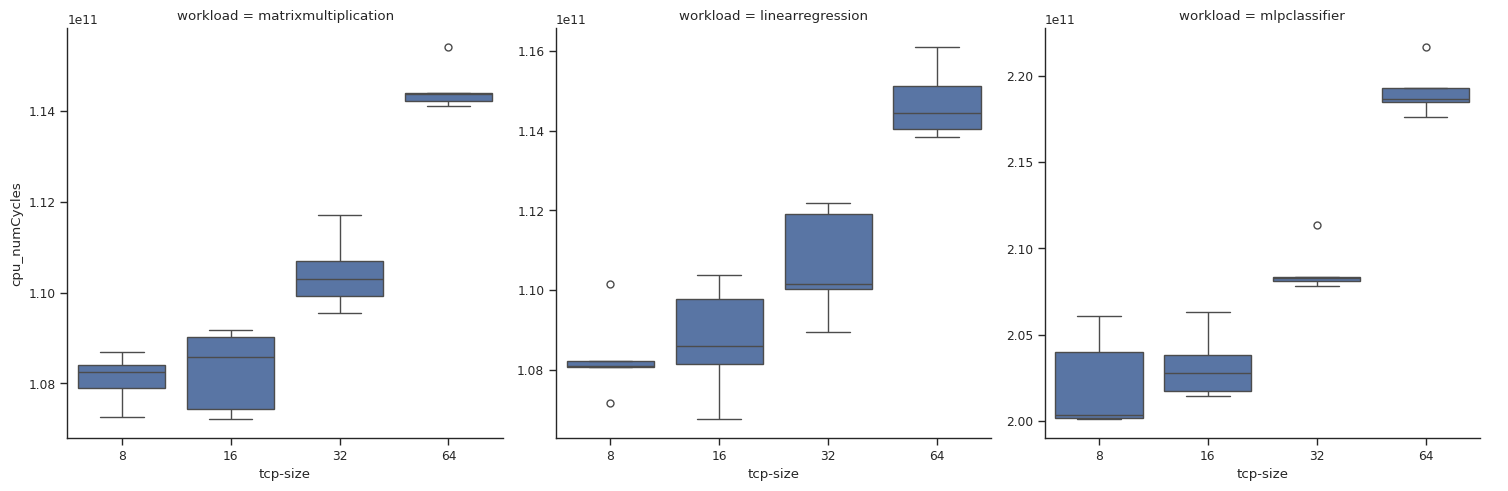

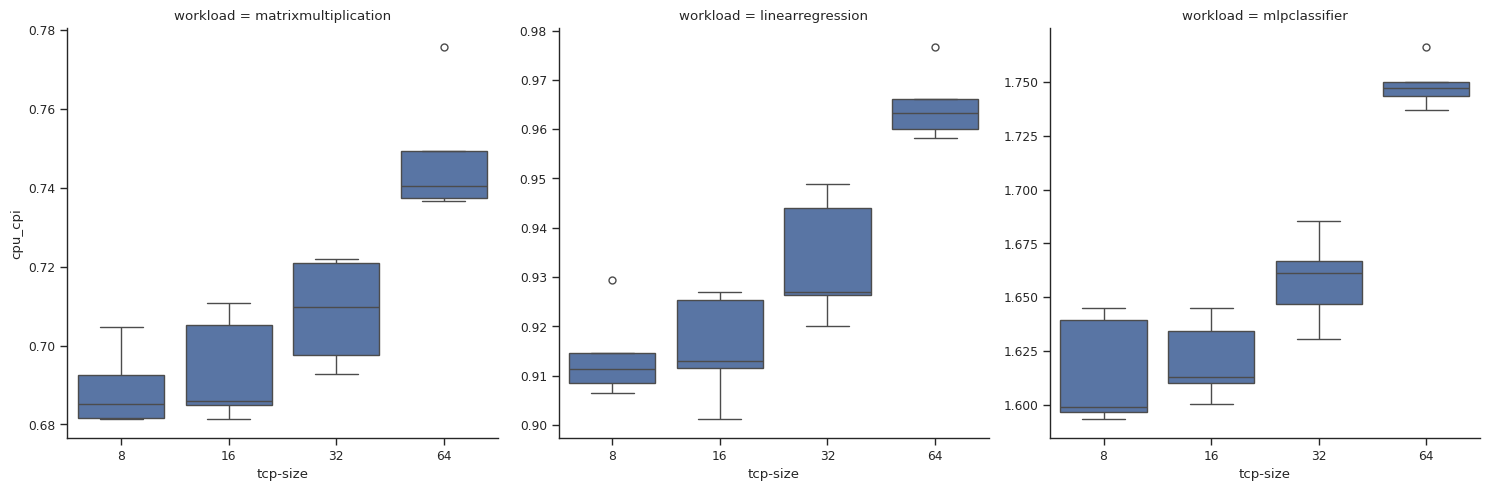

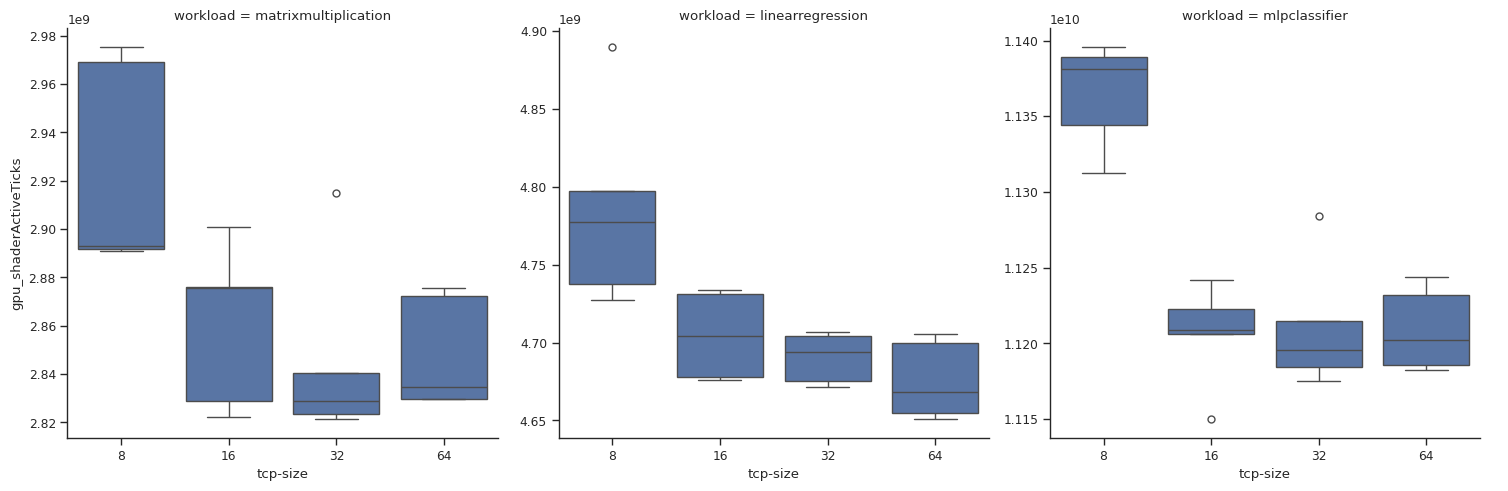

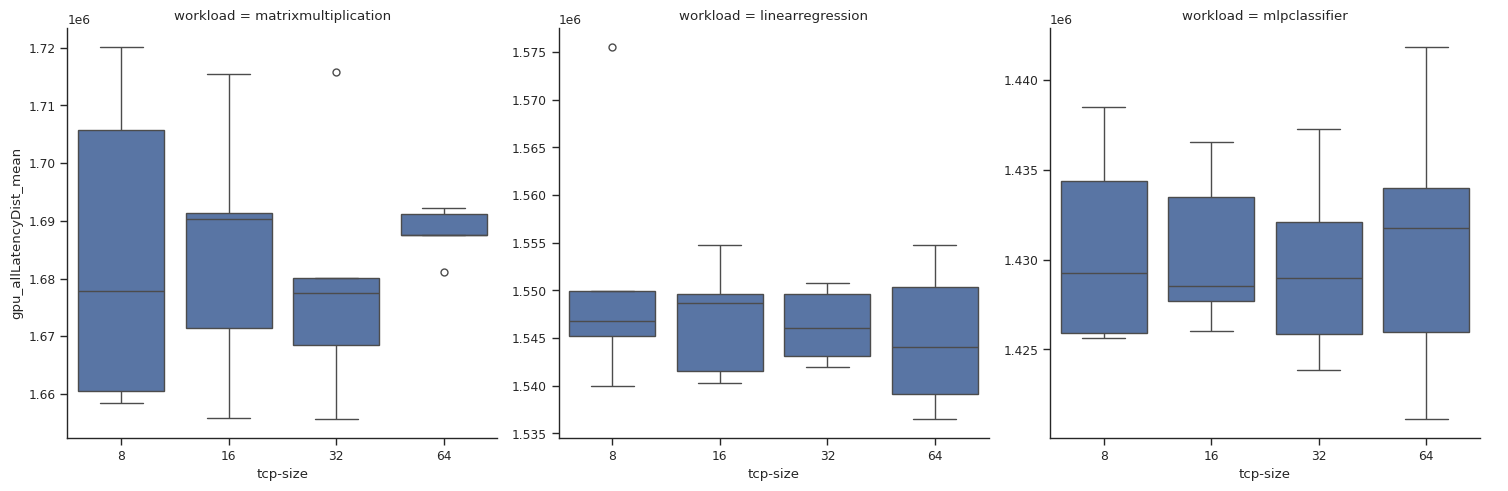

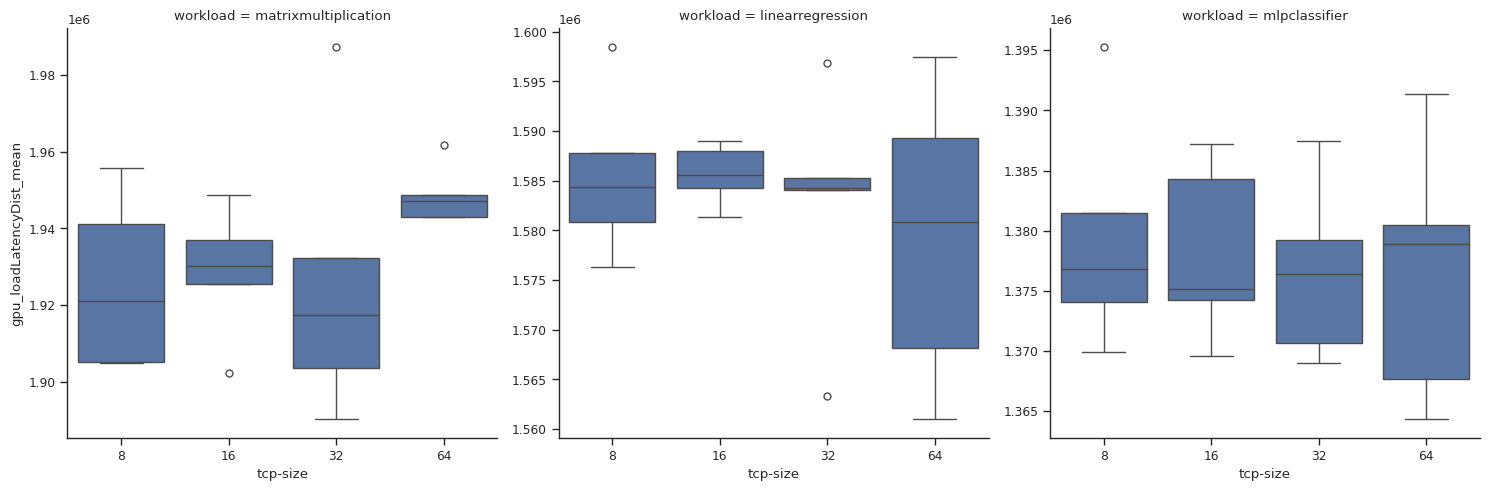

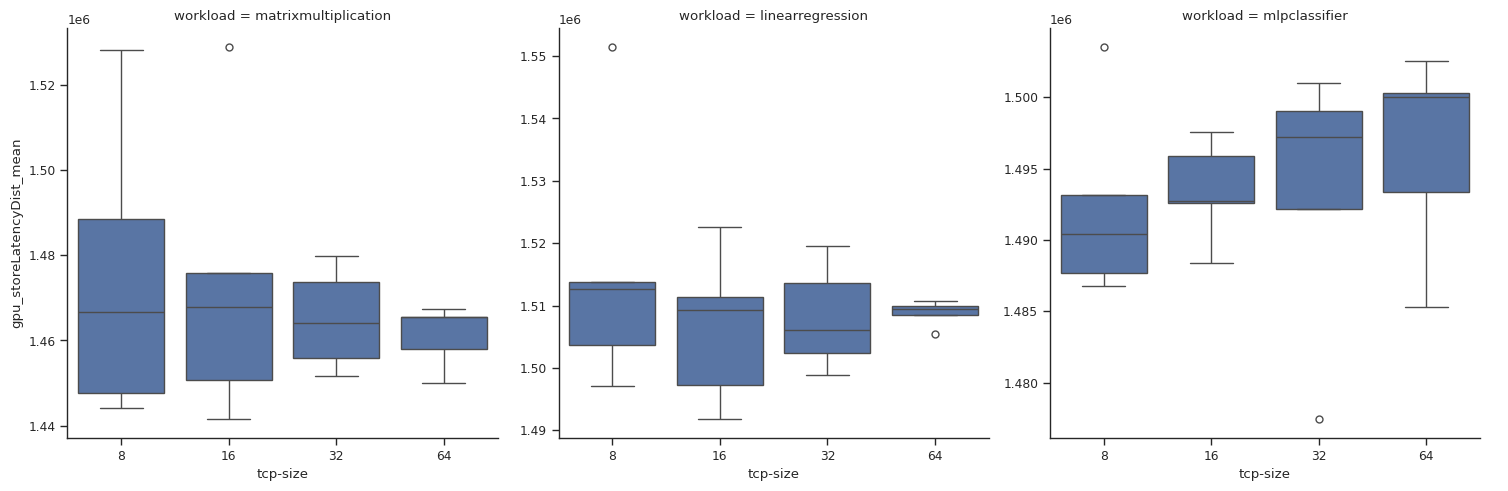

In [13]:
for param in params:
    for stat in stats:
        g = plot(param, stat, workload_order)
        plt.show()

# **Results Section**

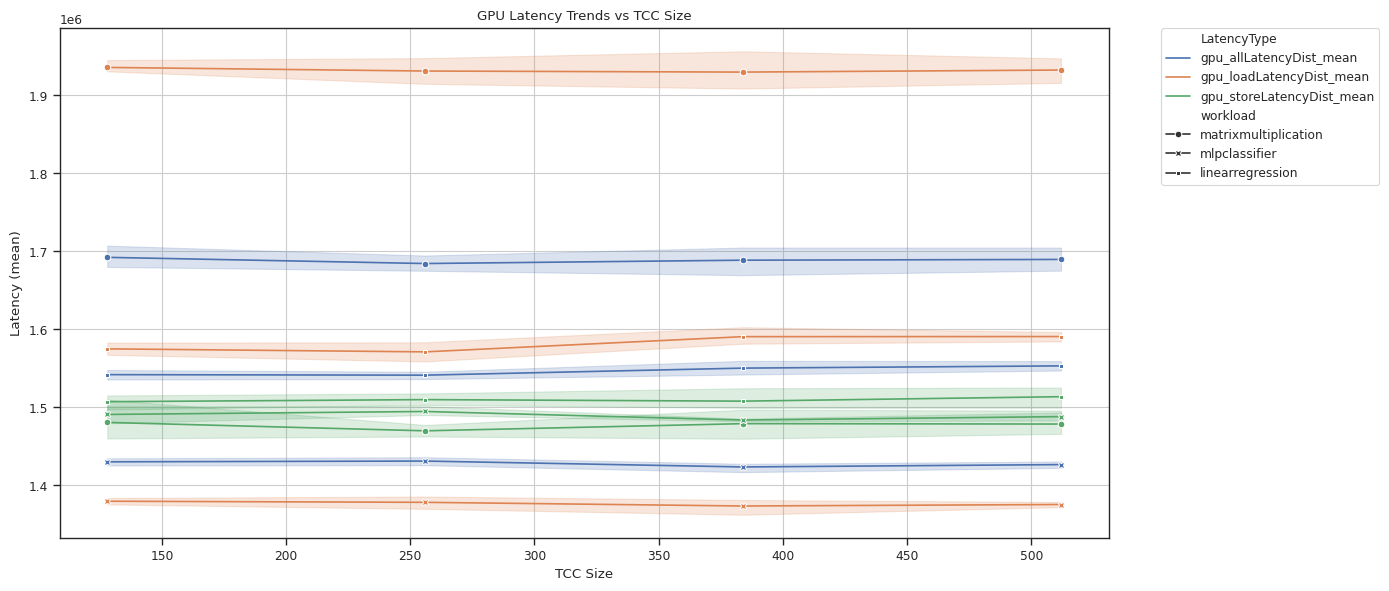

In [48]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_melted,
    x='value',
    y='LatencyValue',
    hue='LatencyType',
    style='workload',
    markers=True,
    dashes=False
)
plt.title('GPU Latency Trends vs TCC Size')
plt.xlabel('TCC Size')
plt.ylabel('Latency (mean)')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

df = pd.read_excel("results.xlsx")
print(df.head())


   run_id              workload              param   value  simSeconds  \
0       4  matrixmultiplication           tcc-size  384KiB   26.669514   
1       4         mlpclassifier          gpu-clock  1.5GHz   16.344841   
2       2         mlpclassifier           tcc-size  512KiB   16.879322   
3       1  matrixmultiplication  num-compute-units       8   26.766785   
4       2  matrixmultiplication  num-compute-units       8   26.553175   

   cpu_numCycles   cpu_cpi  gpu_shaderActiveTicks  gpu_allLatencyDist_mean  \
0   109217736299  0.691438             2903044696             1.712063e+06   
1   198372807533  1.584366            10799610252             1.398363e+06   
2   204453338965  1.633284            11195185207             1.431748e+06   
3   108424912483  0.686939             2675788696             3.019773e+06   
4   108557166470  0.682561             2682980696             3.077512e+06   

   gpu_loadLatencyDist_mean  gpu_storeLatencyDist_mean  
0              1.979659e+06  

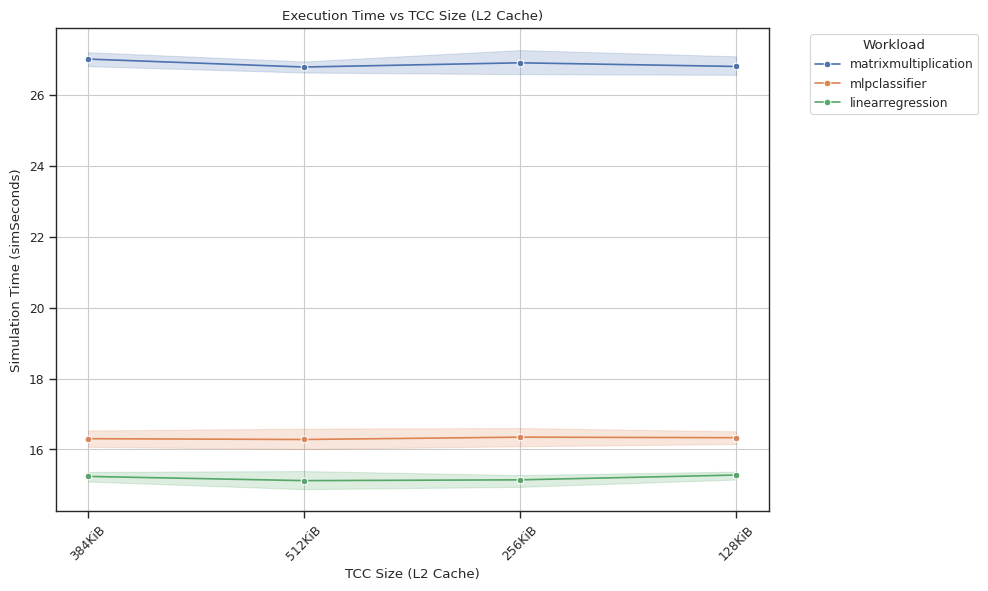

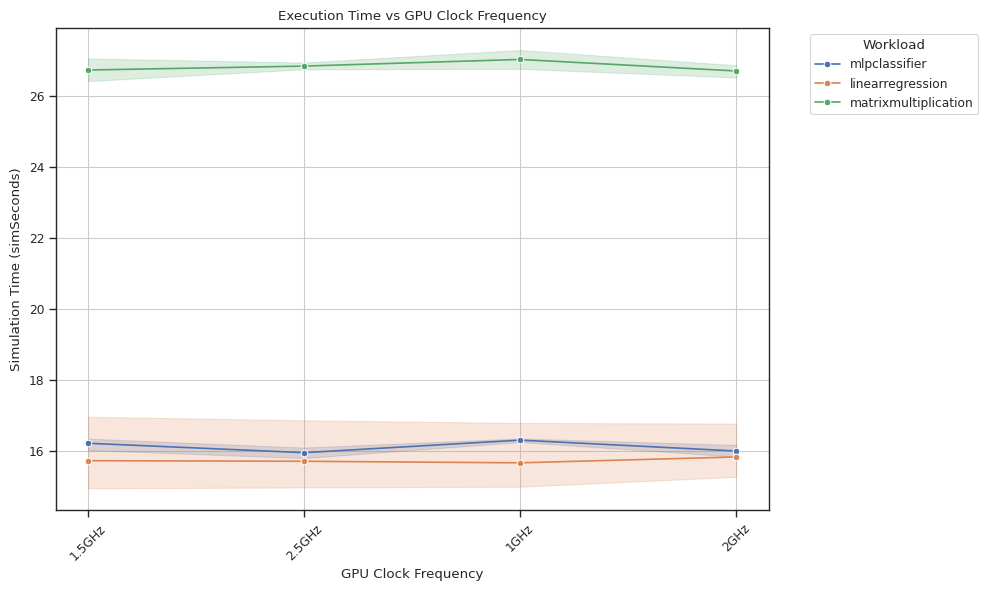

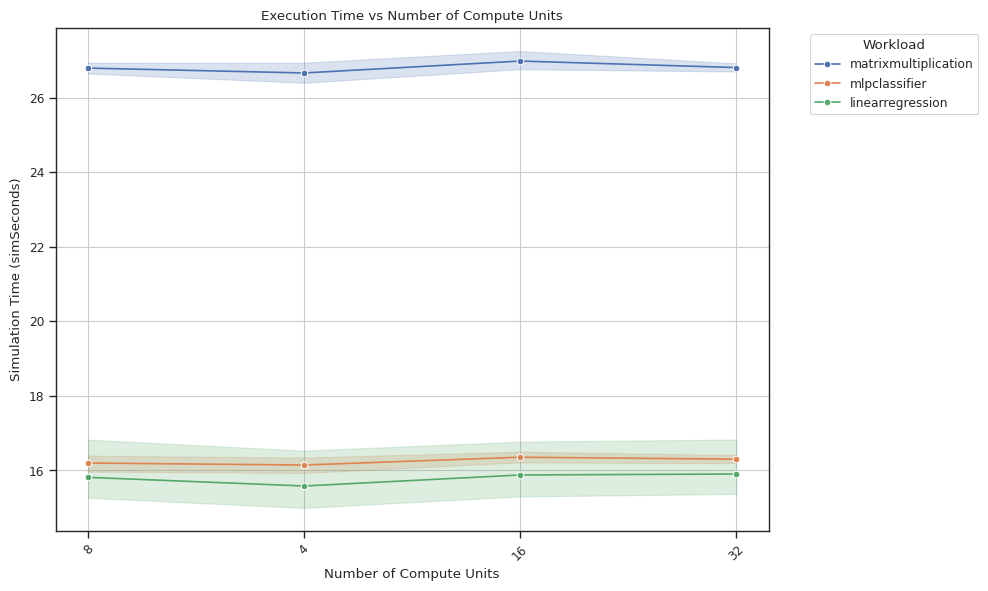

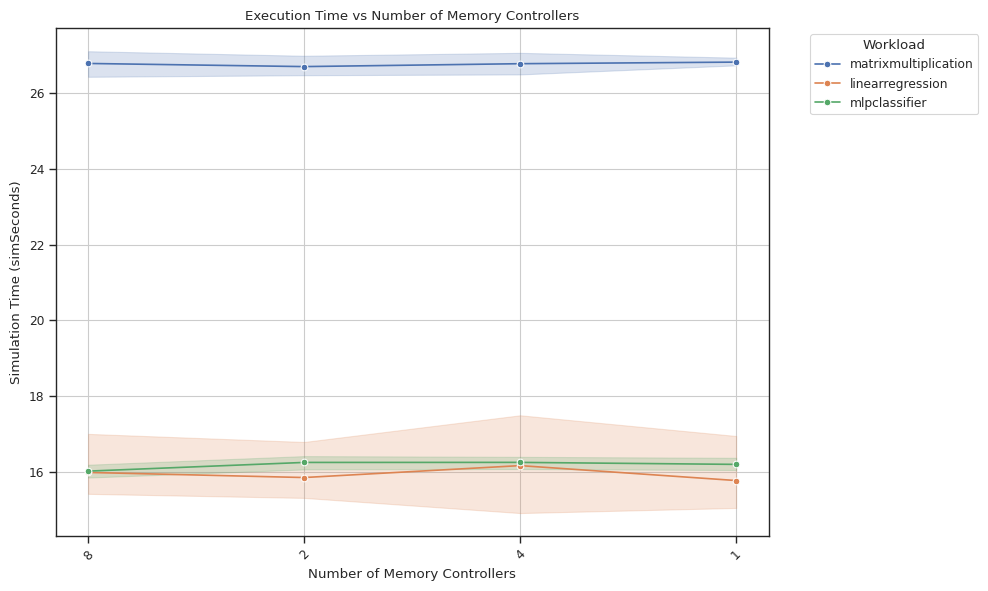

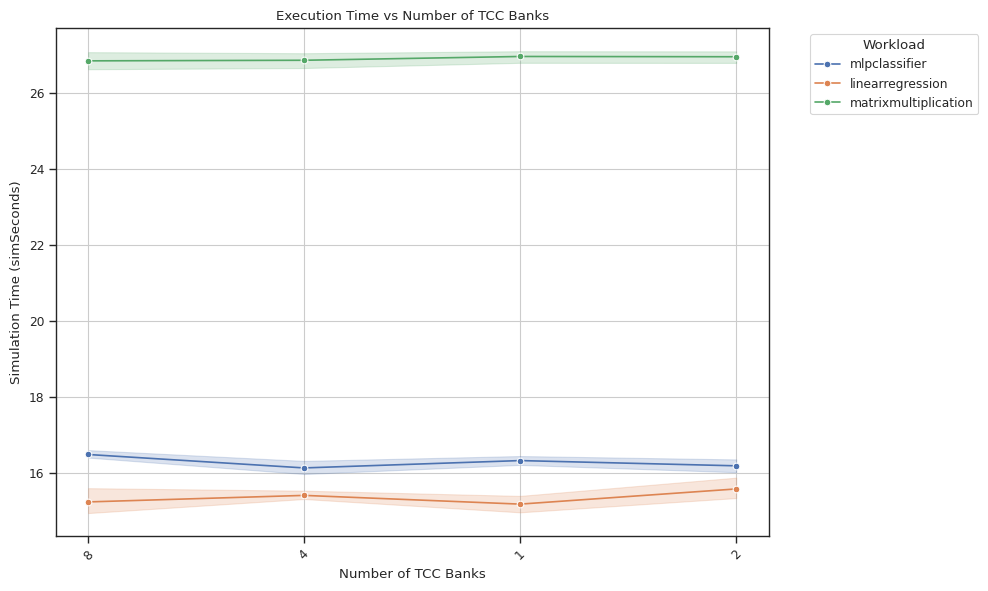

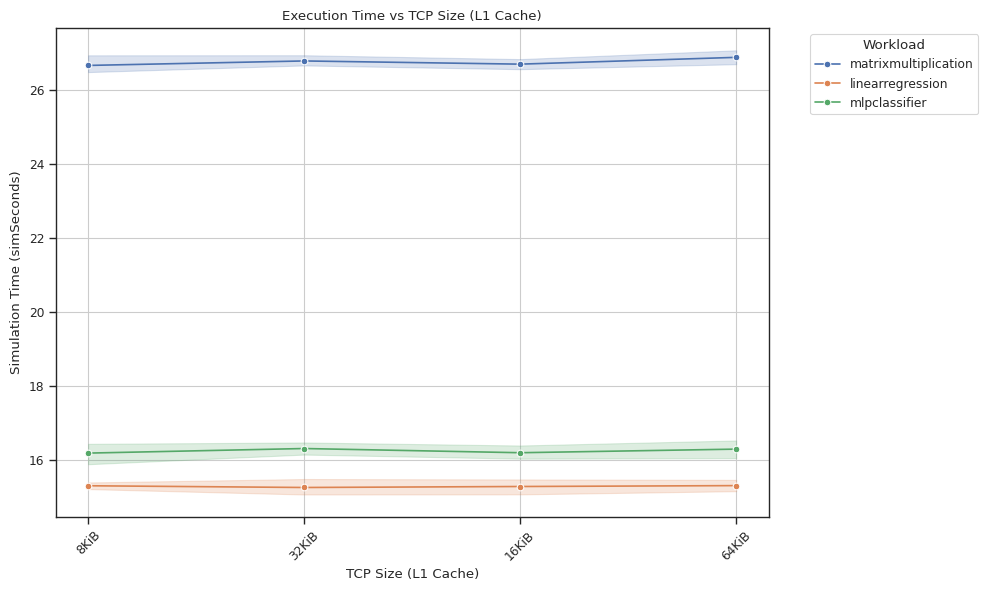

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


param_labels = {
    "tcc-size": "TCC Size (L2 Cache)",
    "gpu-clock": "GPU Clock Frequency",
    "num-compute-units": "Number of Compute Units",
    "dgpu-num-dirs": "Number of Memory Controllers",
    "num-tccs": "Number of TCC Banks",
    "tcp-size": "TCP Size (L1 Cache)"
}


for param in df['param'].unique():
    subset = df[df['param'] == param].copy()
    subset['param_label'] = param_labels.get(param, param)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x='value', y='simSeconds', hue='workload', marker='o')
    plt.title(f'Execution Time vs {param_labels[param]}')
    plt.xlabel(param_labels[param])
    plt.ylabel('Simulation Time (simSeconds)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Workload', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


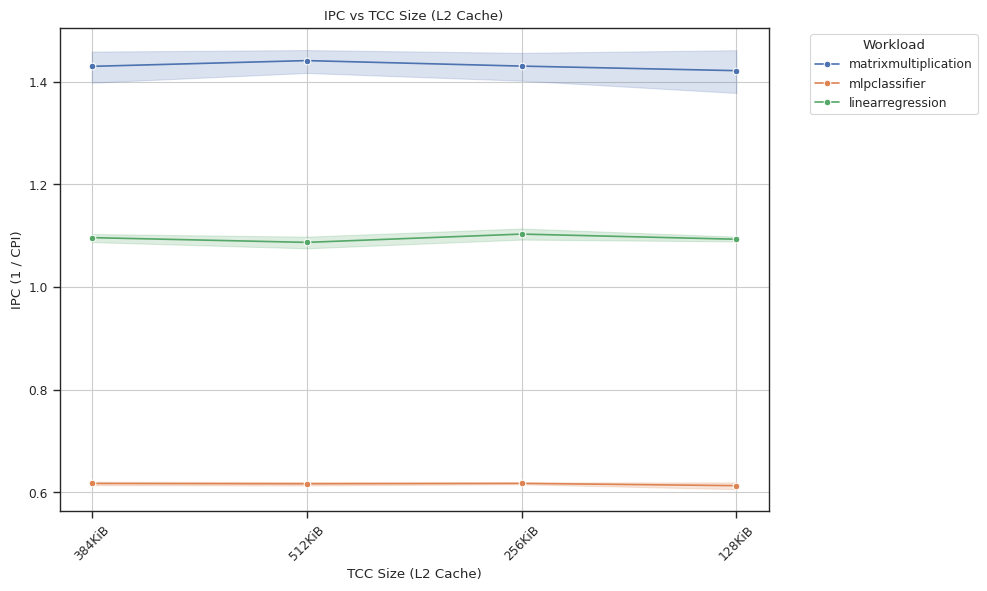

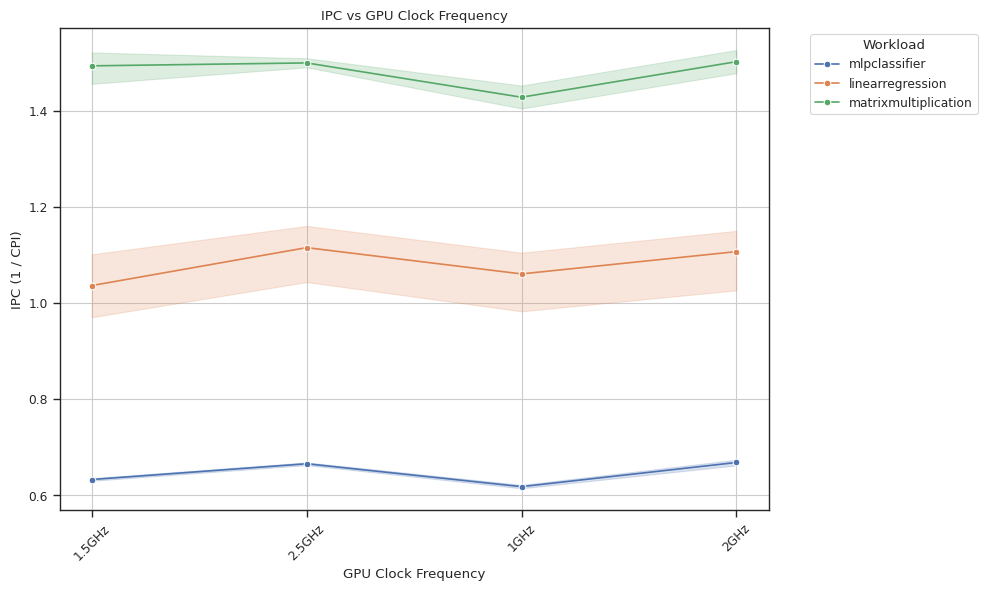

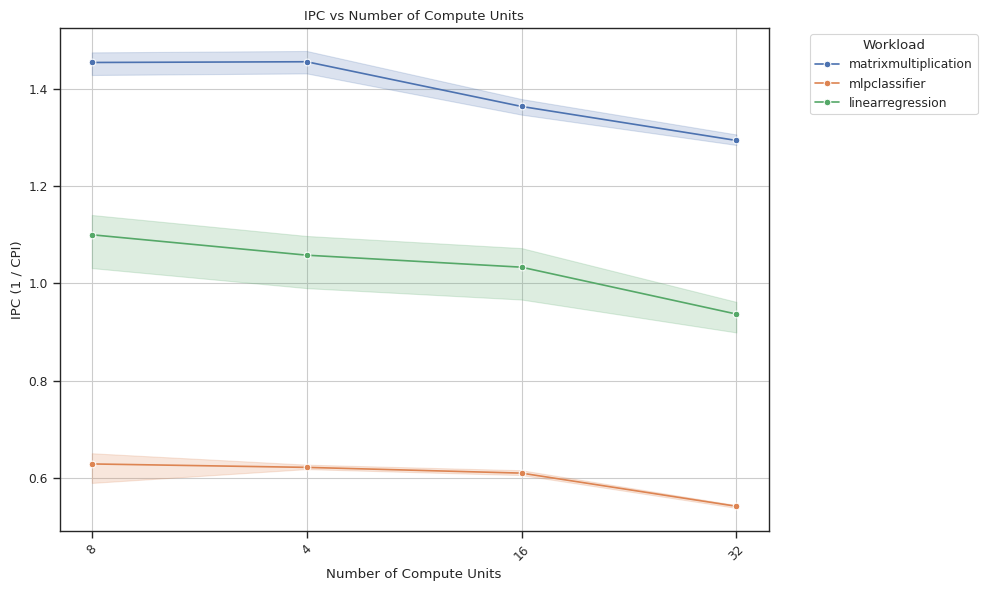

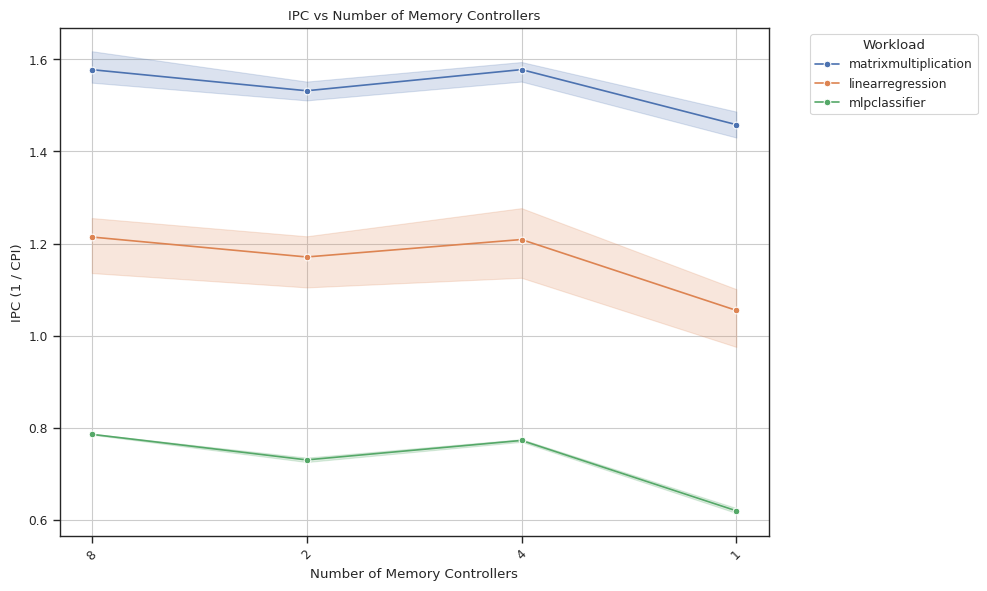

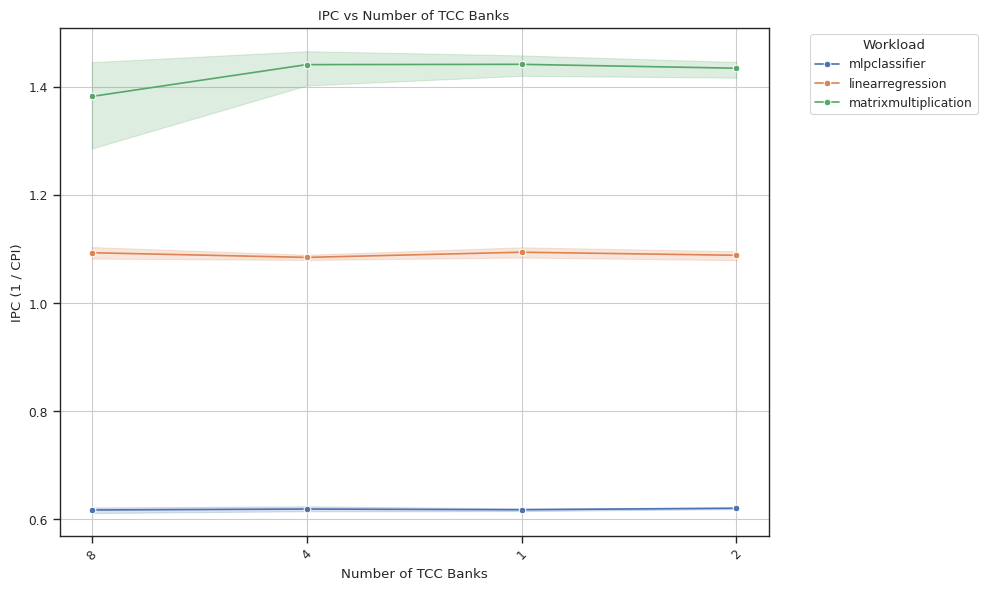

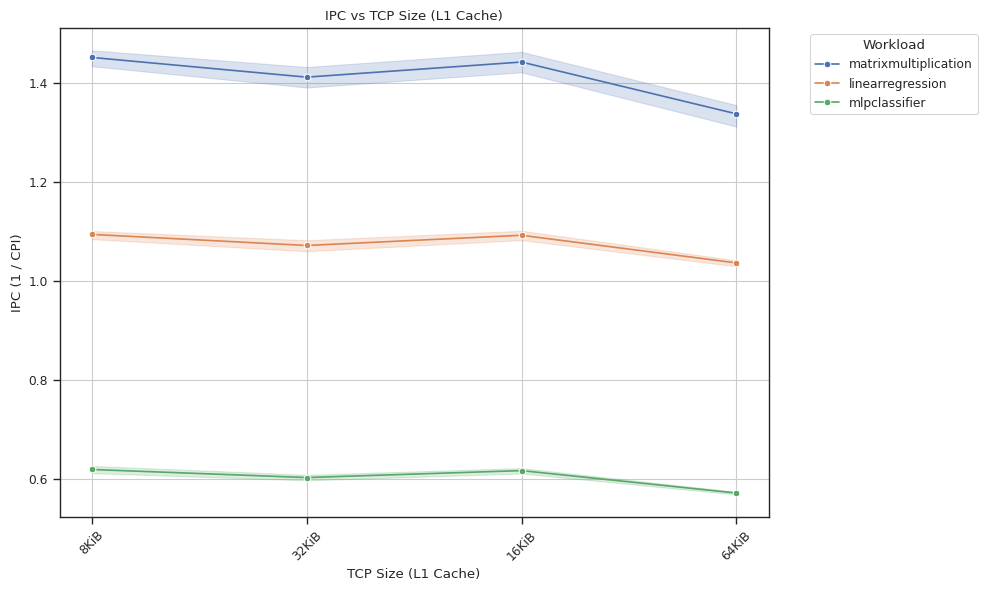

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df['ipc'] = 1 / df['cpu_cpi']


param_labels = {
    "tcc-size": "TCC Size (L2 Cache)",
    "gpu-clock": "GPU Clock Frequency",
    "num-compute-units": "Number of Compute Units",
    "dgpu-num-dirs": "Number of Memory Controllers",
    "num-tccs": "Number of TCC Banks",
    "tcp-size": "TCP Size (L1 Cache)"
}


for param in df['param'].unique():
    subset = df[df['param'] == param].copy()
    subset['param_label'] = param_labels.get(param, param)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x='value', y='ipc', hue='workload', marker='o')
    plt.title(f'IPC vs {param_labels[param]}')
    plt.xlabel(param_labels[param])
    plt.ylabel('IPC (1 / CPI)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Workload', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


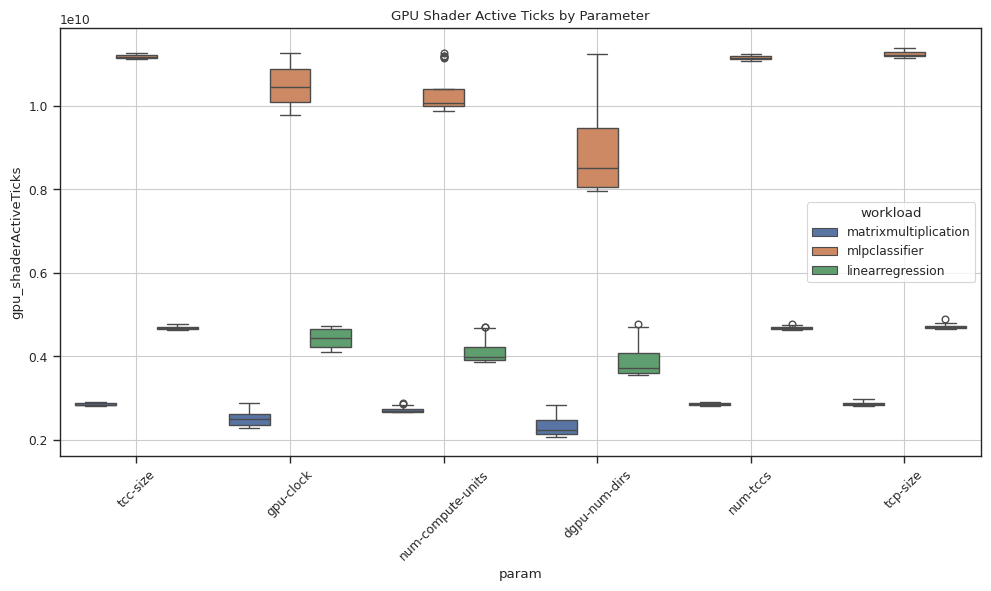

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='param', y='gpu_shaderActiveTicks', hue='workload')
plt.title('GPU Shader Active Ticks by Parameter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


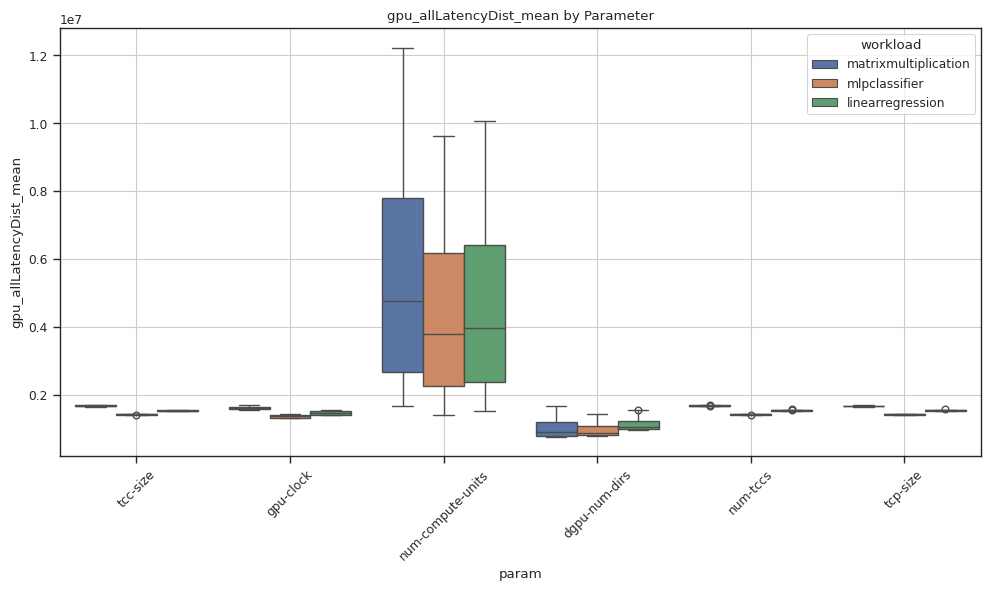

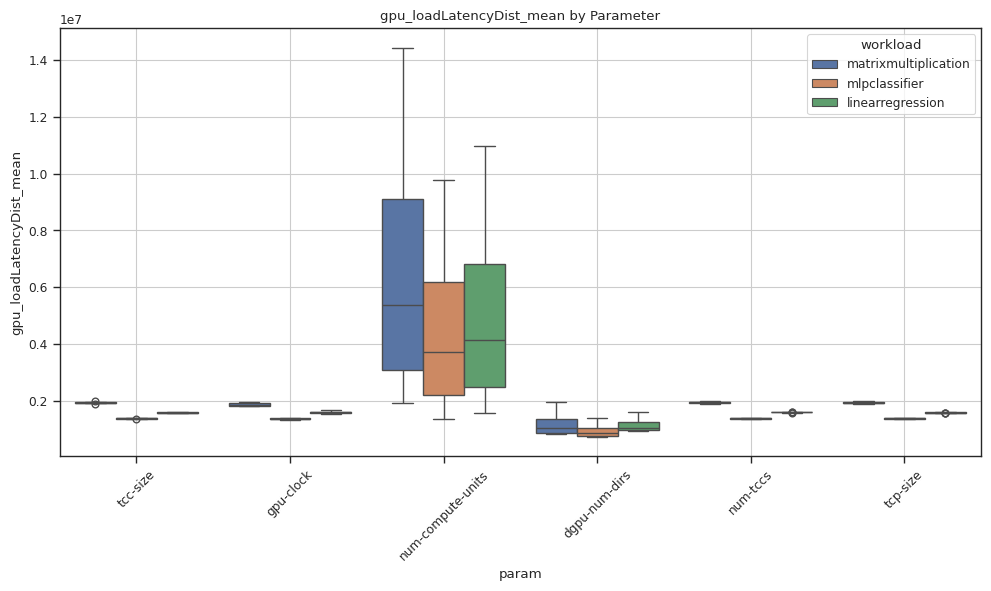

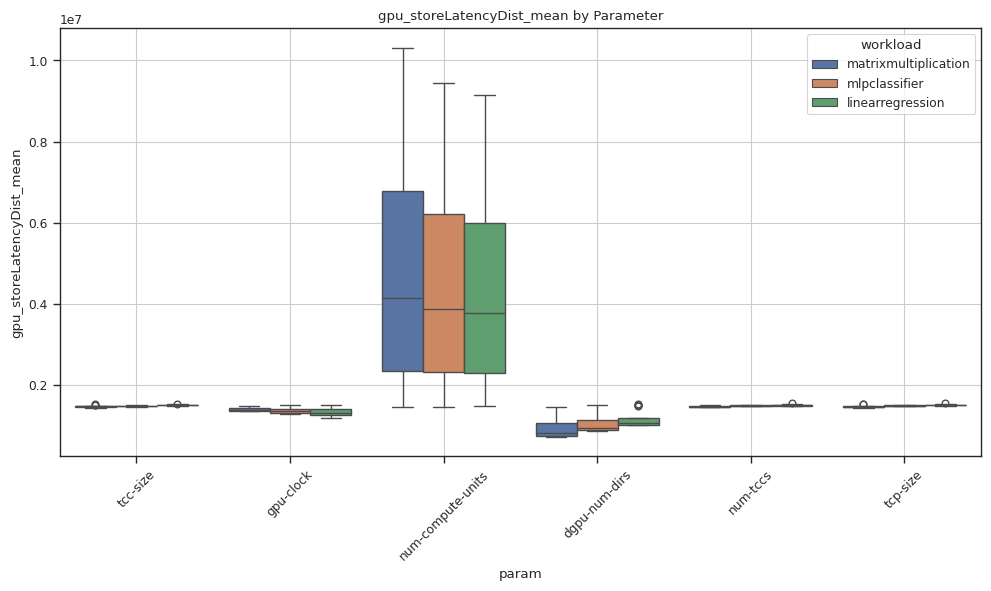

In [19]:
latency_metrics = ['gpu_allLatencyDist_mean', 'gpu_loadLatencyDist_mean', 'gpu_storeLatencyDist_mean']
for metric in latency_metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='param', y=metric, hue='workload')
    plt.title(f'{metric} by Parameter')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


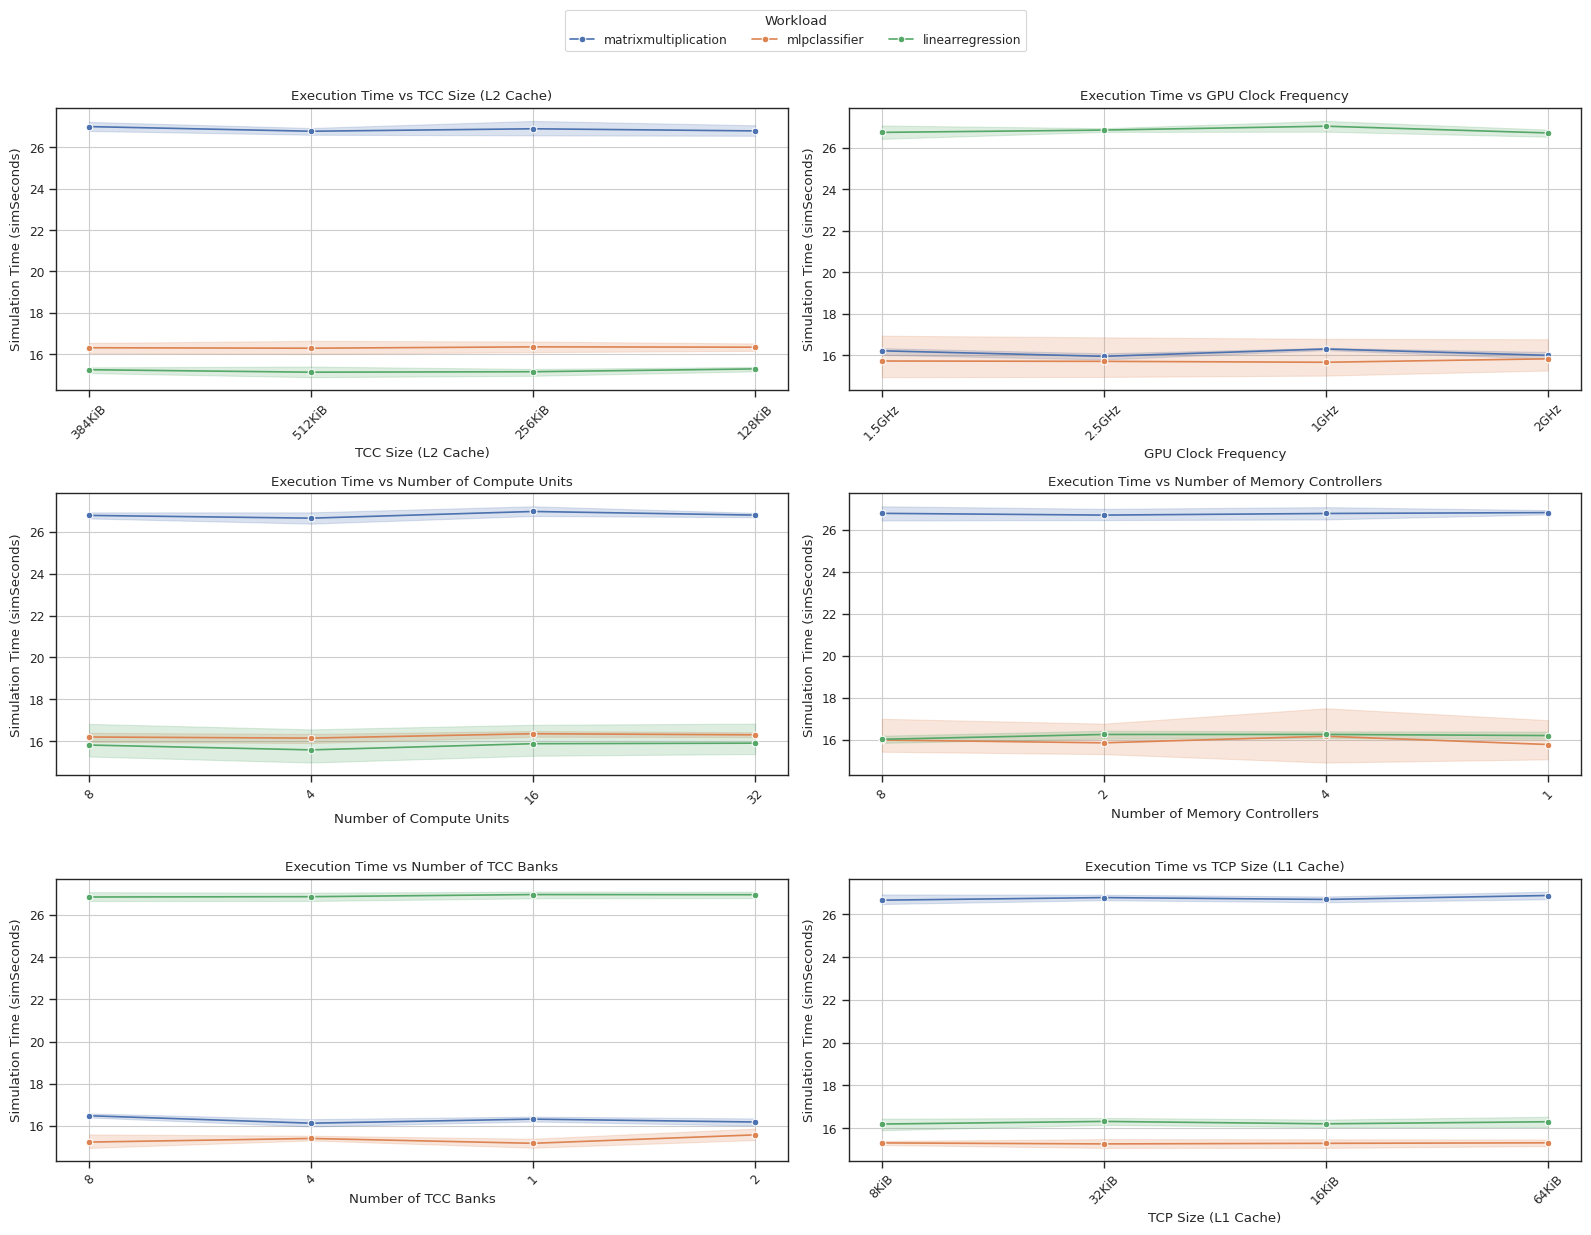

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


param_labels = {
    "tcc-size": "TCC Size (L2 Cache)",
    "gpu-clock": "GPU Clock Frequency",
    "num-compute-units": "Number of Compute Units",
    "dgpu-num-dirs": "Number of Memory Controllers",
    "num-tccs": "Number of TCC Banks",
    "tcp-size": "TCP Size (L1 Cache)"
}

params = list(param_labels.keys())


fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()


handles = labels = None


for i, param in enumerate(params):
    subset = df[df['param'] == param].copy()
    subset['param_label'] = param_labels[param]

    ax = axes[i]
    plot = sns.lineplot(ax=ax, data=subset, x='value', y='simSeconds', hue='workload', marker='o')
    ax.set_title(f'Execution Time vs {param_labels[param]}')
    ax.set_xlabel(param_labels[param])
    ax.set_ylabel('Simulation Time (simSeconds)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)


    if handles is None or labels is None:
        handles, labels = ax.get_legend_handles_labels()

    ax.get_legend().remove()


fig.legend(handles, labels, title='Workload', loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


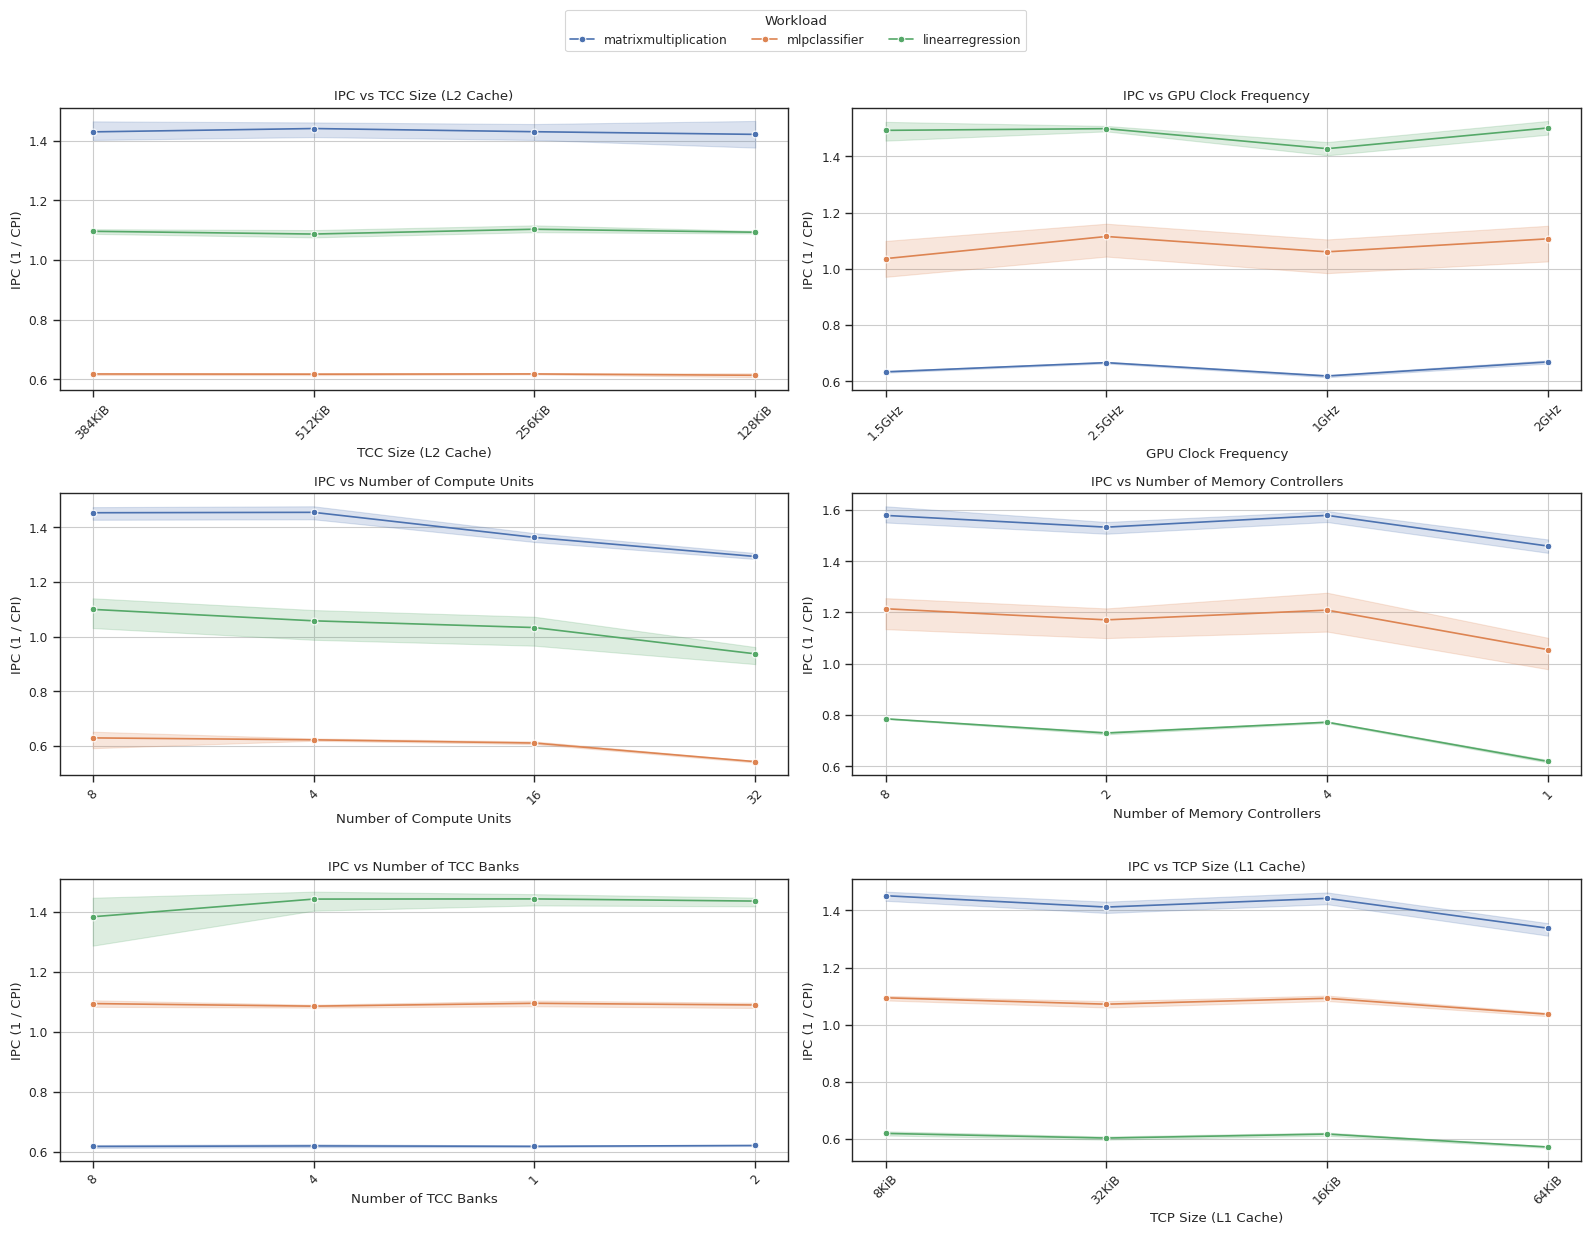

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df['ipc'] = 1 / df['cpu_cpi']


param_labels = {
    "tcc-size": "TCC Size (L2 Cache)",
    "gpu-clock": "GPU Clock Frequency",
    "num-compute-units": "Number of Compute Units",
    "dgpu-num-dirs": "Number of Memory Controllers",
    "num-tccs": "Number of TCC Banks",
    "tcp-size": "TCP Size (L1 Cache)"
}

params = list(param_labels.keys())


fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()


handles = labels = None


for i, param in enumerate(params):
    subset = df[df['param'] == param].copy()
    subset['param_label'] = param_labels[param]

    ax = axes[i]
    plot = sns.lineplot(ax=ax, data=subset, x='value', y='ipc', hue='workload', marker='o')
    ax.set_title(f'IPC vs {param_labels[param]}')
    ax.set_xlabel(param_labels[param])
    ax.set_ylabel('IPC (1 / CPI)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)


    if handles is None or labels is None:
        handles, labels = ax.get_legend_handles_labels()

    ax.get_legend().remove()


fig.legend(handles, labels, title='Workload', loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
